# Creative Writing Scoring using Machine Learning

## Preliminary Data Analysis

In [204]:
# Import Pandas for data frame integration
import pandas as pd

In [205]:
# Code to upload .csv file from desktop location to Colab
from google.colab import files
uploaded = files.upload()

Saving StoryResults.csv to StoryResults (2).csv


In [206]:
# Read in .csv file with story data that will train and test models
StoryResults = pd.read_csv("StoryResults.csv")

In [207]:
# Ensure that the data was loaded properly
StoryResults.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [208]:
# Sample some Pandas dataframe features
StoryResults = StoryResults[["ID","Story","RaterMean"]]

In [209]:
# View results (this table is not used past this cell)
StoryResults.head()

,ID,Story,RaterMean
0,1,My lover has left. I miss him so much. I write...,2.4
1,2,My mom was sending me a letter in the mail abo...,3.0
2,3,I had to buy a stamp at the post office. I am ...,2.2
3,4,I decided it was time for me to send my mom an...,4.2
4,5,Rachel was sitting in her dorm and decided to ...,2.2


## Text Embedding

For our text embedding models, we will be using John Snow Lab's pretrained transformer models. In this notebook, we are using a large version of the BERT sentence embedding model, implementing it with a pipeline for seamless tokenization and embedding results. We are doing embeddings based on a sentence-by-sentence level, with two different methods of calculating the predicted score: averaged embeddings and averaged story-by-story sentence results.

In [210]:
# Code needed to load pretrained models into Colab with Java
import os
! apt-get update -qq > /dev/null   
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
# Local PySpark install to Colab
! pip install nlu pyspark==2.4.7
# NLU package import to use embedding models
import nlu

In [211]:
# Create dataframe with the stories .csv file
df = pd.read_csv('StoryResults.csv')
df.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [212]:
# Convert all stories to lowercase for embedding to work with uncased model
for i in range(len(df['Story'])):
  df['Story'][i] = df['Story'][i].lower()

In [213]:
# Check to see if lowercase function worked
df.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,my lover has left. i miss him so much. i write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,my mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,i had to buy a stamp at the post office. i am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,i decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [214]:
# Create a pipeline to load pretrained TensorFlow Hub embeddings model
pipe = nlu.load('embed_sentence.bert_large_uncased')
# For each story, create an array of stories with subarrays that contain the sentence embeddings for each
# sentence in the story
predictions = pipe.predict(df.Story, output_level='document')
predictions

sent_bert_large_uncased download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,sentence_embeddings@sent_bert_large_uncased_embeddings,origin_index,document_results
0,"[[-0.5021669268608093, -0.2796482443809509, -0...",0,my lover has left. i miss him so much. i write...
1,"[[-0.35134053230285645, 0.005123681388795376, ...",1,my mom was sending me a letter in the mail abo...
2,"[[-0.3492274880409241, -0.1999286562204361, -0...",2,i had to buy a stamp at the post office. i am ...
3,"[[-0.3730190396308899, -0.2264404594898224, -0...",3,i decided it was time for me to send my mom an...
4,"[[-0.5186511278152466, -0.23248396813869476, -...",4,rachel was sitting in her dorm and decided to ...
...,...,...,...
174,"[[-0.1484881341457367, -0.25832271575927734, -...",174,i decided to mail a letter to my long lost fri...
175,"[[-0.42180758714675903, -0.20135170221328735, ...",175,my friend from home enlisted in the air force;...
176,"[[-0.6956300139427185, -0.15601441264152527, -...",176,i wanted to write a letter to my dog. i sealed...
177,"[[-0.2498113363981247, -0.14632295072078705, -...",177,my husband had just left for the war and i had...


In [215]:
# Add the rater mean to the table, so it can be used for training and testing labels later on
predictions["RaterMean"] = df["RaterMean"]

In [216]:
predictions.head()

,sentence_embeddings@sent_bert_large_uncased_embeddings,origin_index,document_results,RaterMean
0,"[[-0.5021669268608093, -0.2796482443809509, -0...",0,my lover has left. i miss him so much. i write...,2.4
1,"[[-0.35134053230285645, 0.005123681388795376, ...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[-0.3492274880409241, -0.1999286562204361, -0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[-0.3730190396308899, -0.2264404594898224, -0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[-0.5186511278152466, -0.23248396813869476, -...",4,rachel was sitting in her dorm and decided to ...,2.2


In [217]:
# Check to see the number of vectors in each of the sentence embeddings
print(len(predictions['sentence_embeddings@sent_bert_large_uncased_embeddings'][8][2]))

1024


In [218]:
# Change the long name of the embeddings column to "embed"
predictions = predictions.rename(columns={'sentence_embeddings@sent_bert_large_uncased_embeddings':'embed'})

In [219]:
predictions

,embed,origin_index,document_results,RaterMean
0,"[[-0.5021669268608093, -0.2796482443809509, -0...",0,my lover has left. i miss him so much. i write...,2.4
1,"[[-0.35134053230285645, 0.005123681388795376, ...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[-0.3492274880409241, -0.1999286562204361, -0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[-0.3730190396308899, -0.2264404594898224, -0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[-0.5186511278152466, -0.23248396813869476, -...",4,rachel was sitting in her dorm and decided to ...,2.2
...,...,...,...,...
174,"[[-0.1484881341457367, -0.25832271575927734, -...",174,i decided to mail a letter to my long lost fri...,2.6
175,"[[-0.42180758714675903, -0.20135170221328735, ...",175,my friend from home enlisted in the air force;...,2.2
176,"[[-0.6956300139427185, -0.15601441264152527, -...",176,i wanted to write a letter to my dog. i sealed...,4.0
177,"[[-0.2498113363981247, -0.14632295072078705, -...",177,my husband had just left for the war and i had...,3.4


In [220]:
# Split the arrays for each story into their own sentence-by-sentence rows
# Store the embeddings
sent_embed = []
# Store the ID
story_id = []
# Store the labels of each story that the sentences belong to 
rater_score = []
for i in range(len(predictions['embed'])):
  for j in range(len(predictions['embed'][i])):
    sent_embed.append(predictions['embed'][i][j])
    story_id.append(predictions['origin_index'][i])
    rater_score.append(predictions['RaterMean'][i])

In [221]:
# Create a new dataframe where the rows are individual sentences from all the stories
# Start by making sure the sentences can be grouped later with the stories they belong to
model_data = pd.DataFrame(story_id)
# Add the embeddings
model_data['sent_embed'] = sent_embed
# Add the rater score for the story that each sentence belongs to
model_data['rater_score'] = rater_score
model_data = model_data.rename(columns={0:'story_id'})

In [222]:
model_data

,story_id,sent_embed,rater_score
0,0,"[-0.5021669268608093, -0.2796482443809509, -0....",2.4
1,0,"[-0.39397215843200684, -0.14956806600093842, -...",2.4
2,1,"[-0.35134053230285645, 0.005123681388795376, -...",3.0
3,1,"[-0.4149269759654999, -0.08932187408208847, -0...",3.0
4,1,"[-0.1747816652059555, -0.08245997875928879, -0...",3.0
...,...,...,...
546,176,"[-0.3492797315120697, -0.12968365848064423, -0...",4.0
547,177,"[-0.2498113363981247, -0.14632295072078705, -0...",3.4
548,178,"[-0.022642897441983223, 0.38562047481536865, -...",4.4
549,178,"[-0.19302518665790558, -0.05842367187142372, 0...",4.4


In [223]:
# Create columns for each vector in the sentence embeddings
columns = []
for i in range(len(model_data["sent_embed"][0])):
  columns.append("Vector"+str(i))
len(columns)

1024

In [224]:
# Split the arrays into their respective vectors
embedData = pd.DataFrame(model_data['sent_embed'].to_list(), columns=columns)
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector984,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023
0,-0.502167,-0.279648,-0.059644,-0.316028,-0.073892,-0.121070,0.475643,0.292423,0.394305,-0.048281,0.153509,-0.098703,-0.779101,-0.352649,0.253751,-0.255775,0.239941,-0.297050,-0.146083,-0.264028,-0.359106,0.088713,-0.473386,-0.411048,-0.304156,0.330929,0.247159,-0.237099,0.022037,0.142361,-0.023916,0.431819,0.112208,-0.416476,-0.411829,0.061721,0.324138,-0.245228,0.149559,-0.214709,...,0.277554,0.177784,-0.274921,-0.277461,-0.200875,-0.122602,0.056494,0.006643,-0.452588,-0.329958,-0.172499,0.070264,0.030366,0.069059,-0.159991,0.194125,-0.548737,0.013692,-0.008774,-0.015593,0.236754,-0.620972,0.145270,0.069050,-0.508089,0.098026,-0.306305,-0.224987,0.018418,-0.344541,0.013399,0.069988,-0.267821,-0.086811,0.188764,0.207743,0.053899,-0.176313,0.177871,-0.171710
1,-0.393972,-0.149568,-0.345327,0.004947,-0.247056,-0.277602,0.307601,0.308401,0.073347,0.029369,0.431123,0.089464,-0.594635,-0.220028,0.162223,-0.201169,-0.123500,-0.066940,-0.186597,-0.300435,-0.331049,0.093710,-0.228731,-0.183703,-0.374797,0.273178,-0.022406,-0.054702,0.090330,0.458919,-0.133793,0.028420,0.067536,-0.170262,-0.006815,-0.493530,0.399243,-0.333090,0.031648,-0.144447,...,0.190849,0.022735,-0.154807,-0.144344,0.115887,-0.031700,-0.066744,-0.118483,-0.131813,-0.099775,-0.048598,0.012566,0.236186,0.007330,0.009274,0.114983,0.011197,0.130874,-0.272632,0.243187,0.234263,-0.355836,0.169658,-0.178076,-0.700731,0.091712,-0.346826,0.008651,0.006163,-0.296083,0.246637,0.141845,-0.501426,-0.291362,-0.015242,0.267279,0.220346,-0.087312,-0.020961,-0.136577
2,-0.351341,0.005124,-0.426304,0.039732,-0.258680,0.013792,0.248841,0.494768,0.359494,0.183843,0.227959,-0.030479,-0.580935,-0.340377,0.153166,-0.485332,-0.095812,-0.098349,0.201941,-0.259485,-0.375052,0.083415,-0.320851,-0.475193,-0.222989,0.197816,0.828710,-0.025138,0.228979,0.395106,0.191898,0.201792,0.212607,-0.485974,-0.065629,-0.117943,0.484466,-0.019383,0.070442,0.001150,...,0.309889,0.272895,-0.465886,-0.124967,-0.236570,-0.379285,0.007816,-0.067619,-0.249733,-0.318950,-0.018459,-0.057829,0.190731,0.370259,-0.178140,-0.057829,-0.484846,-0.097640,0.397636,0.064805,0.117390,-0.665502,0.251373,-0.102341,-0.552942,-0.309756,-0.223036,-0.155120,-0.171128,-0.147410,0.086390,0.064695,-0.295186,-0.239183,0.128992,0.376219,0.023324,-0.286501,0.268643,-0.105927
3,-0.414927,-0.089322,-0.305613,-0.134026,-0.440057,-0.039942,0.378598,0.187421,0.087443,0.315930,0.346122,0.325365,-0.392492,-0.110538,0.096548,0.200916,0.046564,-0.053369,0.252728,-0.269063,-0.119169,-0.054965,-0.385884,-0.159591,-0.378486,0.407621,0.295855,-0.025019,0.415738,0.425980,0.061792,-0.022522,0.168152,-0.246703,0.006477,-0.062404,0.005417,-0.179739,0.061866,-0.272928,...,-0.122172,-0.145240,-0.372494,-0.152403,-0.566930,-0.110261,0.029514,0.285118,0.090479,-0.186905,-0.142748,0.043843,0.031065,0.193382,0.067943,0.108845,-0.371322,-0.097972,0.067783,-0.052052,0.120291,-0.497365,0.201953,0.120663,-0.477979,0.038551,-0.411567,-0.103952,0.095104,0.041749,0.120950,-0.054814,-0.487955,-0.041913,0.170232,0.257685,0.068661,-0.253359,0.088073,0.095734
4,-0.174782,-0.082460,-0.152608,0.096513,-0.193793,-0.067427,0.342433,0.233131,0.284132,0.384325,0.301910,-0.185411,-0.347144,-0.227477,0.091602,

In [225]:
# Add the rater mean and story ID to the new table
embedData["RaterMean"] = model_data["rater_score"]
embedData["StoryID"] = model_data["story_id"]
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,RaterMean,StoryID
0,-0.502167,-0.279648,-0.059644,-0.316028,-0.073892,-0.121070,0.475643,0.292423,0.394305,-0.048281,0.153509,-0.098703,-0.779101,-0.352649,0.253751,-0.255775,0.239941,-0.297050,-0.146083,-0.264028,-0.359106,0.088713,-0.473386,-0.411048,-0.304156,0.330929,0.247159,-0.237099,0.022037,0.142361,-0.023916,0.431819,0.112208,-0.416476,-0.411829,0.061721,0.324138,-0.245228,0.149559,-0.214709,...,-0.274921,-0.277461,-0.200875,-0.122602,0.056494,0.006643,-0.452588,-0.329958,-0.172499,0.070264,0.030366,0.069059,-0.159991,0.194125,-0.548737,0.013692,-0.008774,-0.015593,0.236754,-0.620972,0.145270,0.069050,-0.508089,0.098026,-0.306305,-0.224987,0.018418,-0.344541,0.013399,0.069988,-0.267821,-0.086811,0.188764,0.207743,0.053899,-0.176313,0.177871,-0.171710,2.4,0
1,-0.393972,-0.149568,-0.345327,0.004947,-0.247056,-0.277602,0.307601,0.308401,0.073347,0.029369,0.431123,0.089464,-0.594635,-0.220028,0.162223,-0.201169,-0.123500,-0.066940,-0.186597,-0.300435,-0.331049,0.093710,-0.228731,-0.183703,-0.374797,0.273178,-0.022406,-0.054702,0.090330,0.458919,-0.133793,0.028420,0.067536,-0.170262,-0.006815,-0.493530,0.399243,-0.333090,0.031648,-0.144447,...,-0.154807,-0.144344,0.115887,-0.031700,-0.066744,-0.118483,-0.131813,-0.099775,-0.048598,0.012566,0.236186,0.007330,0.009274,0.114983,0.011197,0.130874,-0.272632,0.243187,0.234263,-0.355836,0.169658,-0.178076,-0.700731,0.091712,-0.346826,0.008651,0.006163,-0.296083,0.246637,0.141845,-0.501426,-0.291362,-0.015242,0.267279,0.220346,-0.087312,-0.020961,-0.136577,2.4,0
2,-0.351341,0.005124,-0.426304,0.039732,-0.258680,0.013792,0.248841,0.494768,0.359494,0.183843,0.227959,-0.030479,-0.580935,-0.340377,0.153166,-0.485332,-0.095812,-0.098349,0.201941,-0.259485,-0.375052,0.083415,-0.320851,-0.475193,-0.222989,0.197816,0.828710,-0.025138,0.228979,0.395106,0.191898,0.201792,0.212607,-0.485974,-0.065629,-0.117943,0.484466,-0.019383,0.070442,0.001150,...,-0.465886,-0.124967,-0.236570,-0.379285,0.007816,-0.067619,-0.249733,-0.318950,-0.018459,-0.057829,0.190731,0.370259,-0.178140,-0.057829,-0.484846,-0.097640,0.397636,0.064805,0.117390,-0.665502,0.251373,-0.102341,-0.552942,-0.309756,-0.223036,-0.155120,-0.171128,-0.147410,0.086390,0.064695,-0.295186,-0.239183,0.128992,0.376219,0.023324,-0.286501,0.268643,-0.105927,3.0,1
3,-0.414927,-0.089322,-0.305613,-0.134026,-0.440057,-0.039942,0.378598,0.187421,0.087443,0.315930,0.346122,0.325365,-0.392492,-0.110538,0.096548,0.200916,0.046564,-0.053369,0.252728,-0.269063,-0.119169,-0.054965,-0.385884,-0.159591,-0.378486,0.407621,0.295855,-0.025019,0.415738,0.425980,0.061792,-0.022522,0.168152,-0.246703,0.006477,-0.062404,0.005417,-0.179739,0.061866,-0.272928,...,-0.372494,-0.152403,-0.566930,-0.110261,0.029514,0.285118,0.090479,-0.186905,-0.142748,0.043843,0.031065,0.193382,0.067943,0.108845,-0.371322,-0.097972,0.067783,-0.052052,0.120291,-0.497365,0.201953,0.120663,-0.477979,0.038551,-0.411567,-0.103952,0.095104,0.041749,0.120950,-0.054814,-0.487955,-0.041913,0.170232,0.257685,0.068661,-0.253359,0.088073,0.095734,3.0,1
4,-0.174782,-0.082460,-0.152608,0.096513,-0.193793,-0.067427,0.342433,0.233131,0.284132,0.384325,0.301910,-0.185411,-0.347144,-0.227477,0.091602,-0.063166,-0.180939,-0.166806,0.310950,-0.460884,-0.

In [226]:
# Create another dataframe for the first method that averages the embeddings of the sentences
# grouped by the stories that they are part of
modelData = embedData.groupby(['StoryID']).mean()

In [227]:
modelData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,RaterMean
StoryID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.448070,-0.214608,-0.202486,-0.155541,-0.160474,-0.199336,0.391622,0.300412,0.233826,-0.009456,0.292316,-0.004619,-0.686868,-0.286338,0.207987,-0.228472,0.058221,-0.181995,-0.166340,-0.282231,-0.345077,0.091212,-0.351058,-0.297376,-0.339477,0.302054,0.112377,-0.145901,0.056184,0.300640,-0.078854,0.230120,0.089872,-0.293369,-0.209322,-0.215904,0.361690,-0.289159,0.090603,-0.179578,...,0.100260,-0.214864,-0.210902,-0.042494,-0.077151,-0.005125,-0.055920,-0.292201,-0.214867,-0.110549,0.041415,0.133276,0.038195,-0.075359,0.154554,-0.268770,0.072283,-0.140703,0.113797,0.235509,-0.488404,0.157464,-0.054513,-0.604410,0.094869,-0.326565,-0.108168,0.012290,-0.320312,0.130018,0.105917,-0.384624,-0.189087,0.086761,0.237511,0.137123,-0.131812,0.078455,-0.154143,2.4
1,-0.355675,-0.065366,-0.287009,0.040060,-0.364729,-0.012346,0.362176,0.308935,0.211645,0.287745,0.248773,0.086847,-0.470404,-0.208010,0.143868,-0.097625,-0.050287,-0.093652,0.283140,-0.331731,-0.249722,-0.061385,-0.352362,-0.263130,-0.297645,0.271410,0.438508,-0.048102,0.305154,0.409419,0.191562,0.076907,0.250381,-0.346337,-0.016061,-0.051775,0.244337,-0.125844,0.123351,-0.111249,...,0.069158,-0.300679,-0.170187,-0.331775,-0.163652,0.037111,0.182377,-0.120658,-0.248645,-0.137331,0.015721,0.048681,0.260580,-0.085753,0.038854,-0.401890,-0.007099,0.192162,-0.015596,0.180490,-0.582762,0.188336,0.044491,-0.508459,-0.078608,-0.290137,-0.116747,0.017848,-0.031670,0.210780,0.044596,-0.350281,-0.138395,0.204257,0.320906,-0.023980,-0.296464,0.094793,0.022625,3.0
2,-0.260214,-0.188201,-0.355376,-0.051398,-0.335581,-0.175600,0.337005,0.303096,0.083593,0.024543,0.167969,-0.020866,-0.480512,-0.258692,0.087913,-0.234333,-0.137939,-0.167934,-0.016339,-0.257810,-0.431153,-0.101682,-0.294535,-0.184852,-0.242883,0.137425,0.294515,-0.062830,0.119260,0.281270,-0.013603,0.028613,0.071928,-0.387550,-0.050742,-0.132449,0.250459,-0.215989,0.124792,-0.178256,...,0.193460,-0.287675,-0.202112,-0.147568,-0.065419,0.006883,0.053958,-0.085415,-0.320134,-0.038724,0.087086,0.339372,0.259679,-0.318780,0.055497,-0.404193,0.089012,-0.027734,0.113764,0.134457,-0.374540,0.166129,0.078901,-0.474338,-0.059881,-0.177402,-0.083566,-0.061792,-0.312042,0.228594,0.044182,-0.334232,-0.258857,0.112655,0.379494,0.076481,-0.216938,0.151789,-0.155073,2.2
3,-0.278477,-0.068147,-0.345202,-0.026768,-0.180692,-0.113401,0.325298,0.347666,0.139991,0.156011,0.227825,-0.018022,-0.304789,-0.344409,0.024858,-0.317809,-0.103481,-0.025634,-0.114830,-0.380489,-0.212460,0.187935,-0.185129,-0.260340,-0.154991,0.204594,0.429268,0.007703,0.147427,0.486216,-0.086020,-0.106430,0.038797,-0.414532,-0.224395,-0.035616,0.185783,-0.032417,0.128611,-0.109545,...,0.235060,-0.219897,-0.117368,0.016067,-0.151023,0.057143,-0.112395,-0.070811,-0.315751,-0.191674,-0.022180,0.205188,0.180758,-0.232297,0.056726,-0.304510,-0.020052,-0.117206,0.002221,0.290072,-0.383857,0.160094,-0.166167,-0.475240,-0.103085,-0.289528,-0.264472,-0.150565,-0.219168,0.198389,0.049134,-0.346055,-0.262615,0.183327,0.381783,0.001291,-0.170079,0.054340,-0.170242,4.2
4,-0.496363,-0.098428,-0.167055,-0.140483,-0.395252,0.066755,0

## Model Building & Evaluation Results

### Regression Models

Find embeddings for all sentences in the documents as separate rows, average their embedding values, and then run them through linear, ridge, lasso, elastic net, and stochastic gradient descent regression models to get document-level predicted scores.

In [228]:
# Import required packages for model building and visualizations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

#### Linear Regression with Averaged Embeddings

Find embeddings for all sentences in the documents as separate rows, average their embedding values, and then run them through the linear regression model to get document-level predicted scores.

In [229]:
# Get the model data with the average of the embeddings
data = modelData
# Create a numpy array of the embeddings 
X = data.iloc[:, 0:1024].values#.reshape(-1, 1)
# Create a numpy array of the mean rater scores (labels)
Y = data.iloc[:, 1024].values#.reshape(-1, 1)
# Create a numpy array of the index for the stories
I = modelData.index.to_numpy()
# Define the regression models
linear_regressor = LinearRegression()
ridge_regressor = Ridge()
lasso_regressor = Lasso()
elastic_net = ElasticNet()
sgd_regressor = SGDRegressor()

In [230]:
# Check the dimensions of the arrays that were created above
I.shape

(179,)

In [231]:
X.shape

(179, 1024)

In [232]:
Y.shape

(179,)

In [233]:
# Split the data into training and testing sets for the embeddings, labels and indices.
X_train, X_test, Y_train, Y_test, I_train, I_test = train_test_split(X, Y, I, test_size=0.20, random_state=42)

In [234]:
# Check the resulting format
X_test

array([[-0.36355821, -0.16189608, -0.221674  , ..., -0.24127217,
        -0.0397406 , -0.07169473],
       [-0.34478721, -0.18852863, -0.24106956, ..., -0.1986217 ,
         0.20934028, -0.0102708 ],
       [-0.55551995, -0.25895765, -0.14308331, ..., -0.24114331,
         0.22302384,  0.06435961],
       ...,
       [-0.20849301, -0.10580105, -0.27023416, ..., -0.36250441,
         0.16587014, -0.0718627 ],
       [-0.44862409,  0.00790962, -0.39127691, ...,  0.02664428,
         0.13945563, -0.14292289],
       [-0.28514635,  0.00281099, -0.26559301, ..., -0.17022231,
        -0.10771972,  0.01033502]])

In [235]:
# These are identifiers to correctly associate the results with the right stories
I_test

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [236]:
# Fit the regression models with array of averaged embeddings in each story of the training set
linear_regressor.fit(X_train, Y_train)
ridge_regressor.fit(X_train, Y_train)
lasso_regressor.fit(X_train, Y_train)
elastic_net.fit(X_train, Y_train)
sgd_regressor.fit(X_train, Y_train)
# Predict the scores for the testing data with the averaged testing embeddings
Y_pred1 = linear_regressor.predict(X_test)
Y_pred2 = ridge_regressor.predict(X_test)
Y_pred3 = lasso_regressor.predict(X_test)
Y_pred4 = elastic_net.predict(X_test)
Y_pred5 = sgd_regressor.predict(X_test)

In [237]:
# Here are the predicted creativity scores for the test stories, in an array for now
Y_pred1

array([2.9399488 , 3.48413207, 1.93324095, 4.26031169, 2.0474757 ,
       2.10482157, 4.25815995, 1.98636523, 1.1200224 , 3.27609398,
       1.63446196, 0.24123837, 3.40091107, 3.51452406, 1.72946205,
       3.62626661, 1.85052095, 1.93783342, 3.6620183 , 3.13975344,
       4.01740251, 3.38233315, 3.74715223, 2.74548581, 2.21674201,
       2.84939998, 2.73490506, 3.44253267, 2.77384762, 1.95623959,
       2.57088977, 3.40233706, 3.77322457, 2.79673905, 1.73326069,
       4.0231946 ])

In [238]:
# Edit the prediction results to make sure that they are within the bounds of 0 and 5 for the context of the project
for i in range(len(Y_pred1)):
  if Y_pred1[i] < 0:
    Y_pred1[i] = 0
  elif Y_pred1[i] > 5:
    Y_pred1[i] = 5

for i in range(len(Y_pred2)):
  if Y_pred2[i] < 0:
    Y_pred2[i] = 0
  elif Y_pred2[i] > 5:
    Y_pred2[i] = 5

for i in range(len(Y_pred3)):
  if Y_pred3[i] < 0:
    Y_pred3[i] = 0
  elif Y_pred3[i] > 5:
    Y_pred3[i] = 5

for i in range(len(Y_pred4)):
  if Y_pred4[i] < 0:
    Y_pred4[i] = 0
  elif Y_pred4[i] > 5:
    Y_pred4[i] = 5

for i in range(len(Y_pred5)):
  if Y_pred5[i] < 0:
    Y_pred5[i] = 0
  elif Y_pred5[i] > 5:
    Y_pred5[i] = 5

In [239]:
# Check to see if the values updated
Y_pred1

array([2.9399488 , 3.48413207, 1.93324095, 4.26031169, 2.0474757 ,
       2.10482157, 4.25815995, 1.98636523, 1.1200224 , 3.27609398,
       1.63446196, 0.24123837, 3.40091107, 3.51452406, 1.72946205,
       3.62626661, 1.85052095, 1.93783342, 3.6620183 , 3.13975344,
       4.01740251, 3.38233315, 3.74715223, 2.74548581, 2.21674201,
       2.84939998, 2.73490506, 3.44253267, 2.77384762, 1.95623959,
       2.57088977, 3.40233706, 3.77322457, 2.79673905, 1.73326069,
       4.0231946 ])

In [240]:
# Here are the actual rater means for the test stories
Y_test

array([3. , 3.6, 1.8, 3.8, 1.8, 1.4, 4.8, 2.6, 1.8, 4.6, 1.6, 1. , 5. ,
       3. , 2.2, 3.6, 2. , 1.8, 2.8, 2.6, 4. , 3.2, 3.8, 2.4, 1.8, 3.2,
       3.2, 3.6, 3. , 1.4, 3.4, 2.6, 3.4, 3. , 1. , 4.2])

In [241]:
# Here we can calculate some evaluation metrics
from sklearn import metrics

# Explained Variance Score
evs = metrics.explained_variance_score(Y_test, Y_pred1)
# R-Squared Score
r2 = metrics.r2_score(Y_test, Y_pred1)
# Mean Absolute Error
mae = metrics.mean_absolute_error(Y_test, Y_pred1)
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(Y_test, Y_pred1): 
    Y_test, Y_pred1 = np.array(Y_test), np.array(Y_pred1)
    return np.mean(np.abs((Y_test - Y_pred1) / Y_test)) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred1)
# Mean Squared Error
mse = metrics.mean_squared_error(Y_test, Y_pred1)
# Root Mean Squared Error
rmse = metrics.mean_squared_error(Y_test, Y_pred1, squared=False)

print("Evaluation of Averaged Embeddings Method for Linear Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Linear Regression:
 
Explained Variance Score:  0.705403416883355
R-Squared Score:  0.7033686237088067
Mean Absolute Error:  0.4406171458278129
Mean Absolute Percentage Error:  18.860341030181722
Mean Squared Error:  0.32003229597638744
Root Mean Squared Error:  0.5657139701089124


In [242]:
# Correlation
r = np.corrcoef(Y_test, Y_pred1)
print(r)

[[1.         0.84197549]
 [0.84197549 1.        ]]


In [243]:
evs = metrics.explained_variance_score(Y_test, Y_pred2)
r2 = metrics.r2_score(Y_test, Y_pred2)
mae = metrics.mean_absolute_error(Y_test, Y_pred2)
def mean_absolute_percentage_error(Y_test, Y_pred2): 
    Y_test, Y_pred2 = np.array(Y_test), np.array(Y_pred2)
    return np.mean(np.abs((Y_test - Y_pred2) / Y_test)) * 100
mape = mean_absolute_percentage_error(Y_test, Y_pred2)
mse = metrics.mean_squared_error(Y_test, Y_pred2)
rmse = metrics.mean_squared_error(Y_test, Y_pred2, squared=False)
print("Evaluation of Averaged Embeddings Method for Ridge Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Ridge Regression:
 
Explained Variance Score:  0.7344583337389676
R-Squared Score:  0.7328370847388247
Mean Absolute Error:  0.4129368227432313
Mean Absolute Percentage Error:  17.696979168944992
Mean Squared Error:  0.2882391007984457
Root Mean Squared Error:  0.536879037398971


In [244]:
# Correlation
r = np.corrcoef(Y_test, Y_pred2)
print(r)

[[1.         0.85714152]
 [0.85714152 1.        ]]


In [245]:
evs = metrics.explained_variance_score(Y_test, Y_pred3)
r2 = metrics.r2_score(Y_test, Y_pred3)
mae = metrics.mean_absolute_error(Y_test, Y_pred3)
def mean_absolute_percentage_error(Y_test, Y_pred3): 
    Y_test, Y_pred3 = np.array(Y_test), np.array(Y_pred3)
    return np.mean(np.abs((Y_test - Y_pred3) / Y_test)) * 100
mape = mean_absolute_percentage_error(Y_test, Y_pred3)
mse = metrics.mean_squared_error(Y_test, Y_pred3)
rmse = metrics.mean_squared_error(Y_test, Y_pred3, squared=False)
print("Evaluation of Averaged Embeddings Method for Lasso Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Lasso Regression:
 
Explained Variance Score:  2.220446049250313e-16
R-Squared Score:  -4.8398520163583925e-05
Mean Absolute Error:  0.8644133644133645
Mean Absolute Percentage Error:  40.1236861659669
Mean Squared Error:  1.078941105514532
Root Mean Squared Error:  1.0387208987569914


In [246]:
# Correlation
r = np.corrcoef(Y_test, Y_pred3)
print(r)

[[1.00000000e+00 5.70060038e-16]
 [5.70060038e-16 1.00000000e+00]]


In [247]:
evs = metrics.explained_variance_score(Y_test, Y_pred4)
r2 = metrics.r2_score(Y_test, Y_pred4)
mae = metrics.mean_absolute_error(Y_test, Y_pred4)
def mean_absolute_percentage_error(Y_test, Y_pred4): 
    Y_test, Y_pred4 = np.array(Y_test), np.array(Y_pred4)
    return np.mean(np.abs((Y_test - Y_pred4) / Y_test)) * 100
mape = mean_absolute_percentage_error(Y_test, Y_pred4)
mse = metrics.mean_squared_error(Y_test, Y_pred4)
rmse = metrics.mean_squared_error(Y_test, Y_pred4, squared=False)
print("Evaluation of Averaged Embeddings Method for Elastic Net:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Elastic Net:
 
Explained Variance Score:  2.220446049250313e-16
R-Squared Score:  -4.8398520163583925e-05
Mean Absolute Error:  0.8644133644133645
Mean Absolute Percentage Error:  40.1236861659669
Mean Squared Error:  1.078941105514532
Root Mean Squared Error:  1.0387208987569914


In [248]:
# Correlation
r = np.corrcoef(Y_test, Y_pred4)
print(r)

[[1.00000000e+00 5.70060038e-16]
 [5.70060038e-16 1.00000000e+00]]


In [249]:
evs = metrics.explained_variance_score(Y_test, Y_pred5)
r2 = metrics.r2_score(Y_test, Y_pred5)
mae = metrics.mean_absolute_error(Y_test, Y_pred5)
def mean_absolute_percentage_error(Y_test, Y_pred5): 
    Y_test, Y_pred5 = np.array(Y_test), np.array(Y_pred5)
    return np.mean(np.abs((Y_test - Y_pred5) / Y_test)) * 100
mape = mean_absolute_percentage_error(Y_test, Y_pred5)
mse = metrics.mean_squared_error(Y_test, Y_pred5)
rmse = metrics.mean_squared_error(Y_test, Y_pred5, squared=False)
print("Evaluation of Averaged Embeddings Method for SDG Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for SDG Regression:
 
Explained Variance Score:  0.679947010196364
R-Squared Score:  0.6654685812693567
Mean Absolute Error:  0.43155210452898135
Mean Absolute Percentage Error:  17.69397413716155
Mean Squared Error:  0.3609222306527273
Root Mean Squared Error:  0.6007680339804435


In [250]:
# Correlation
r = np.corrcoef(Y_test, Y_pred5)
print(r)

[[1.        0.8286189]
 [0.8286189 1.       ]]


In [251]:
# Create a dataframe with story ID, prediction results and true rater mean
avgData = pd.DataFrame(I_test)
avgData = avgData.rename(columns={0:'StoryID'})
avgData['predRaterMean_lin'] = Y_pred1
avgData['predRaterMean_ridge'] = Y_pred2
avgData['predRaterMean_lasso'] = Y_pred3
avgData['predRaterMean_elnet'] = Y_pred4
avgData['predRaterMean_sdg'] = Y_pred5
avgData['trueRaterMean'] = Y_test

In [252]:
avgData

,StoryID,predRaterMean_lin,predRaterMean_ridge,predRaterMean_lasso,predRaterMean_elnet,predRaterMean_sdg,trueRaterMean
0,78,2.939949,2.896591,2.840559,2.840559,2.850422,3.0
1,16,3.484132,3.498713,2.840559,2.840559,3.468189,3.6
2,65,1.933241,2.043682,2.840559,2.840559,2.095401,1.8
3,114,4.260312,4.064753,2.840559,2.840559,3.741758,3.8
4,76,2.047476,2.216394,2.840559,2.840559,2.286375,1.8
5,19,2.104822,2.253457,2.840559,2.840559,2.427863,1.4
6,122,4.258160,4.154081,2.840559,2.840559,3.836807,4.8
7,24,1.986365,2.070961,2.840559,2.840559,2.224408,2.6
8,66,1.120022,1.303983,2.840559,2.840559,1.702810,1.8
9,152,3.276094,3.429835,2.840559,2.840559,3.278121,4.6


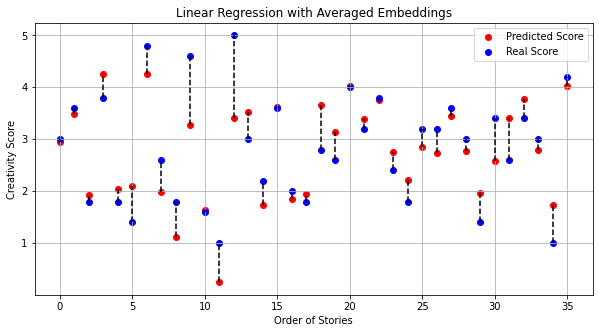

In [253]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred1, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred1[i] >= Y_test[i]:
    topLim = Y_pred1[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred1[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Linear Regression with Averaged Embeddings")
plt.show()

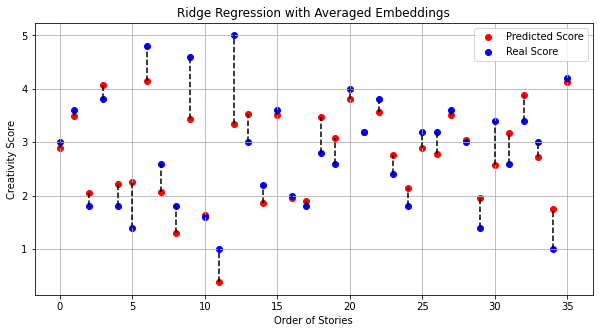

In [254]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred2, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred2[i] >= Y_test[i]:
    topLim = Y_pred2[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred2[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Ridge Regression with Averaged Embeddings")
plt.show()

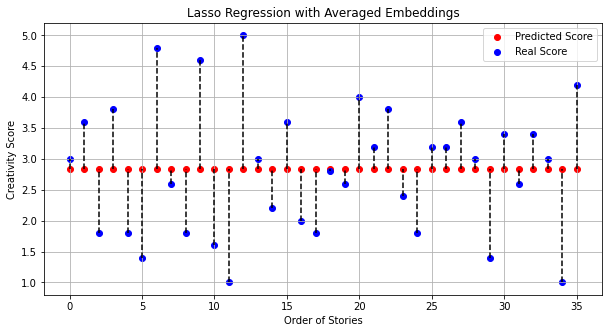

In [255]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred3, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred3[i] >= Y_test[i]:
    topLim = Y_pred3[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred3[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Lasso Regression with Averaged Embeddings")
plt.show()

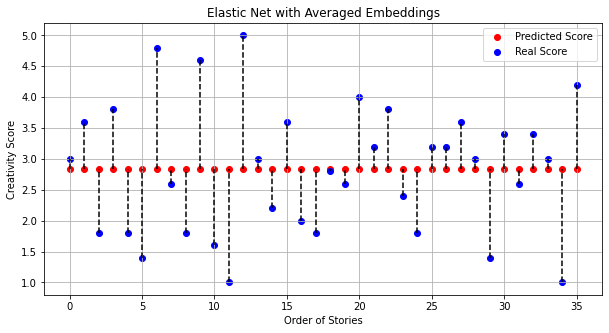

In [256]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred4, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred4[i] >= Y_test[i]:
    topLim = Y_pred4[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred4[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Elastic Net with Averaged Embeddings")
plt.show()

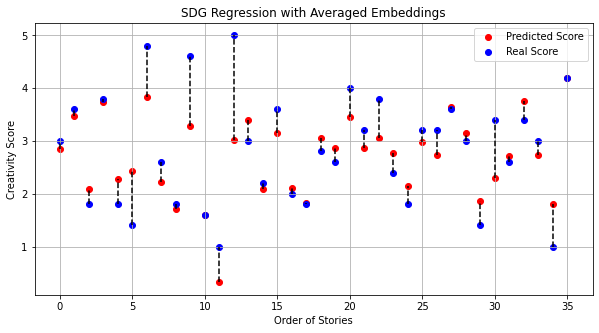

In [257]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred5, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred5[i] >= Y_test[i]:
    topLim = Y_pred5[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred5[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("SDG Regression with Averaged Embeddings")
plt.show()

#### Linear Regression with Sentence Embedding

Find embeddings for all sentences in the documents as separate rows, run them through the linear regression model, and average their predicted scores based on story ID at the end.

In [258]:
# Check the data
predictions

,embed,origin_index,document_results,RaterMean
0,"[[-0.5021669268608093, -0.2796482443809509, -0...",0,my lover has left. i miss him so much. i write...,2.4
1,"[[-0.35134053230285645, 0.005123681388795376, ...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[-0.3492274880409241, -0.1999286562204361, -0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[-0.3730190396308899, -0.2264404594898224, -0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[-0.5186511278152466, -0.23248396813869476, -...",4,rachel was sitting in her dorm and decided to ...,2.2
...,...,...,...,...
174,"[[-0.1484881341457367, -0.25832271575927734, -...",174,i decided to mail a letter to my long lost fri...,2.6
175,"[[-0.42180758714675903, -0.20135170221328735, ...",175,my friend from home enlisted in the air force;...,2.2
176,"[[-0.6956300139427185, -0.15601441264152527, -...",176,i wanted to write a letter to my dog. i sealed...,4.0
177,"[[-0.2498113363981247, -0.14632295072078705, -...",177,my husband had just left for the war and i had...,3.4


In [259]:
# Drop irrelevant column
predictions = predictions.drop(['document_results'], axis=1)

In [260]:
# Check again
predictions

,embed,origin_index,RaterMean
0,"[[-0.5021669268608093, -0.2796482443809509, -0...",0,2.4
1,"[[-0.35134053230285645, 0.005123681388795376, ...",1,3.0
2,"[[-0.3492274880409241, -0.1999286562204361, -0...",2,2.2
3,"[[-0.3730190396308899, -0.2264404594898224, -0...",3,4.2
4,"[[-0.5186511278152466, -0.23248396813869476, -...",4,2.2
...,...,...,...
174,"[[-0.1484881341457367, -0.25832271575927734, -...",174,2.6
175,"[[-0.42180758714675903, -0.20135170221328735, ...",175,2.2
176,"[[-0.6956300139427185, -0.15601441264152527, -...",176,4.0
177,"[[-0.2498113363981247, -0.14632295072078705, -...",177,3.4


In [261]:
# Create the data that will be used for training and testing, this time before story sentences have unique rows
data = predictions
X = data.iloc[:, 0].values#.reshape(-1, 1)  
Y = data.iloc[:, 2].values#.reshape(-1, 1)
I = data.iloc[:, 1].values

In [262]:
# Check the array shapes
X.shape

(179,)

In [263]:
Y.shape

(179,)

In [264]:
I.shape

(179,)

In [265]:
# Perform train test split with embeddings, labels, and indices
X_train, X_test, Y_train, Y_test, I_train, I_test = train_test_split(X, Y, I, test_size=0.20, random_state=42)

In [266]:
# Store the labels for each of the test stories in a holding variable for later scoring
Y_true = Y_test

In [267]:
# Check the embeddings format
X_test

array([array([[-0.16139778, -0.23686989,  0.11322008, ..., -0.14219344,
         0.12107737, -0.08969805],
       [-0.57960582, -0.22955702, -0.3227523 , ..., -0.44643632,
         0.06901605,  0.05773404],
       [-0.37172437, -0.21266802, -0.33381557, ..., -0.20186003,
         0.07469822, -0.13734053],
       [-0.34150487,  0.03151059, -0.34334821, ..., -0.1745989 ,
        -0.42375404, -0.11747438]]),
       array([[-0.38043541, -0.30186552, -0.30568251, ..., -0.36608163,
         0.14068721,  0.02708829],
       [-0.30913901, -0.07519175, -0.1764566 , ..., -0.03116178,
         0.27799335, -0.04762989]]),
       array([[-0.4038367 , -0.20581189, -0.18682128, ..., -0.20437934,
        -0.04423029,  0.01177615],
       [-0.70720321, -0.31210342, -0.09934534, ..., -0.27790728,
         0.49027798,  0.11694307]]),
       array([[-0.47527432, -0.06287002, -0.19983882, ..., -0.32960638,
         0.02429185,  0.39841774],
       [-0.51759839, -0.24504028, -0.35011485, ..., -0.14102313,
 

In [268]:
# Check the story identification format
I_test

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [269]:
# Create a table with the relevant arrays for test data
testData = pd.DataFrame(I_test)
testData = testData.rename(columns={0:'I_test'})
testData['X_test'] = X_test
testData['Y_test'] = Y_test
testData.head()

,I_test,X_test,Y_test
0,78,"[[-0.161397784948349, -0.23686988651752472, 0....",3.0
1,16,"[[-0.38043540716171265, -0.30186551809310913, ...",3.6
2,65,"[[-0.4038366973400116, -0.20581188797950745, -...",1.8
3,114,"[[-0.47527432441711426, -0.06287001818418503, ...",3.8
4,76,"[[-0.17096759378910065, -0.07683245092630386, ...",1.8


In [270]:
# Do the same for the training data
trainData = pd.DataFrame(I_train)
trainData = trainData.rename(columns={0:'I_train'})
trainData['X_train'] = X_train
trainData['Y_train'] = Y_train
trainData.head()

,I_train,X_train,Y_train
0,158,"[[-0.604467511177063, -0.2858034670352936, -0....",1.0
1,31,"[[-0.32658395171165466, 0.06290172040462494, -...",1.2
2,12,"[[-0.6237801313400269, -0.2169693559408188, -0...",1.8
3,51,"[[-0.17888520658016205, -0.4139249920845032, -...",1.6
4,41,"[[-0.40501824021339417, -0.4319823384284973, -...",3.6


In [271]:
# Split the training story sentence embeddings into their own rows
sent_embed = []
story_id = []
rater_score = []

for i in range(len(trainData['X_train'])):
  for j in range(len(trainData['X_train'][i])):
    sent_embed.append(trainData['X_train'][i][j])
    story_id.append(trainData['I_train'][i])
    rater_score.append(trainData['Y_train'][i])

In [272]:
# Create a new train data table with all of the training sentences as rows
trainData = pd.DataFrame(story_id)
trainData['X_train'] = sent_embed
trainData['Y_train'] = rater_score
trainData = trainData.rename(columns={0:'I_train'})

In [273]:
trainData

,I_train,X_train,Y_train
0,158,"[-0.604467511177063, -0.2858034670352936, -0.0...",1.0
1,31,"[-0.32658395171165466, 0.06290172040462494, -0...",1.2
2,31,"[-0.4871496260166168, 0.010226884856820107, -0...",1.2
3,31,"[-0.43376389145851135, -0.07852691411972046, -...",1.2
4,12,"[-0.6237801313400269, -0.2169693559408188, -0....",1.8
...,...,...,...
435,92,"[-0.5269575119018555, -0.4092828631401062, -0....",3.4
436,92,"[-0.2987378239631653, -0.002274555852636695, -...",3.4
437,102,"[-0.14210078120231628, 0.43623650074005127, -0...",3.8
438,102,"[-0.4349157214164734, 0.18269914388656616, 0.3...",3.8


In [274]:
# Create columns for each of the vectors in the training sentence embeddings
columns = []
for i in range(len(trainData["X_train"][0])):
  columns.append("Vector"+str(i))
len(columns)

1024

In [275]:
# Spread the training embeddings into columns 
trainData = pd.DataFrame(trainData['X_train'].to_list(), columns=columns)
trainData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector984,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023
0,-0.604468,-0.285803,-0.063157,-0.173844,-0.487190,0.312375,0.421554,0.397371,0.057594,0.209520,0.038907,0.183119,-0.702787,-0.142498,0.106081,0.028476,-0.149129,-0.197725,0.466947,-0.321303,-0.468378,-0.102491,-0.444652,-0.226180,-0.450437,0.142636,0.234106,-0.055856,0.209941,0.333042,0.413158,0.086596,0.386853,-0.405397,-0.100230,0.058686,0.426450,-0.421642,0.134570,-0.202133,...,-0.005634,0.003512,-0.175824,-0.304877,-0.524751,-0.201190,0.047608,-0.042223,-0.177817,-0.318238,-0.186002,-0.091591,0.136685,0.167487,-0.173436,-0.070649,-0.195311,-0.022365,0.037472,-0.242379,0.209104,-0.732767,0.196102,0.134823,-0.614937,-0.055485,-0.535282,-0.227991,0.121371,-0.367380,0.148053,0.050514,-0.467169,-0.175766,0.317934,0.420604,0.020987,-0.178572,0.445294,-0.058798
1,-0.326584,0.062902,-0.667476,0.066634,-0.125013,-0.186426,0.474420,0.367506,0.223594,-0.034667,0.159271,-0.192047,-0.363108,-0.129890,0.120999,-0.308924,0.086380,-0.217776,-0.223070,-0.046785,-0.389981,0.156745,-0.169243,-0.366560,-0.387505,0.214798,0.269622,-0.267360,-0.154021,0.228330,0.033494,0.118233,-0.035651,-0.419323,-0.127003,-0.266560,0.500974,-0.080176,0.069522,-0.201167,...,0.039820,0.366064,-0.473847,-0.249545,-0.144383,-0.207646,0.176108,-0.036800,-0.125650,-0.397159,-0.093419,0.158738,0.441623,0.200071,-0.168845,-0.052499,-0.346595,0.000008,0.043393,0.093295,0.177660,-0.568326,0.499228,-0.007724,-0.428158,-0.056091,-0.060063,-0.318287,-0.047934,-0.339553,0.014196,0.127850,-0.143493,-0.080142,0.102314,0.355530,0.118545,-0.128844,0.299712,-0.221026
2,-0.487150,0.010227,-0.471214,-0.127439,-0.318105,-0.122909,0.366950,0.160519,0.326359,0.158386,0.321794,0.181225,-0.456804,-0.333192,0.099290,-0.336103,0.062641,-0.007676,-0.198020,-0.150203,-0.284741,0.077204,-0.259681,-0.406631,-0.278788,0.052426,0.751539,0.161609,-0.056307,0.251906,-0.061400,0.163748,-0.002522,-0.489650,0.015075,-0.395689,0.260348,0.055742,-0.182589,0.007297,...,0.163441,0.311908,-0.362544,-0.007714,-0.101142,-0.172348,0.076730,-0.210743,-0.235758,-0.303337,-0.056267,-0.087143,0.442930,0.232367,-0.122001,0.143189,-0.356432,0.185821,-0.011014,0.141045,0.103840,-0.398789,0.286323,-0.269609,-0.693451,-0.058811,-0.208943,-0.228617,-0.512702,-0.090677,0.230004,0.109838,-0.346362,-0.447921,0.102004,0.106289,0.206755,-0.049733,0.417903,-0.164211
3,-0.433764,-0.078527,-0.164410,-0.109231,-0.408005,-0.117436,0.375234,0.362566,0.115903,0.250544,0.209212,0.393784,-0.349824,0.049504,0.094549,-0.090716,-0.048886,-0.094337,0.205659,-0.255217,-0.439911,-0.076071,-0.693025,-0.375659,-0.259031,0.237848,0.197089,-0.209687,0.342167,0.496646,-0.077582,0.066203,0.090692,-0.226130,-0.153165,0.014456,0.189583,-0.334467,0.118981,-0.132223,...,-0.049852,0.042148,-0.267467,-0.072928,-0.402619,-0.037912,-0.003853,0.242488,-0.145076,-0.554912,-0.214102,-0.044444,0.182387,0.415843,0.037453,0.279641,-0.415678,0.064873,0.085822,-0.029531,0.111125,-0.650101,0.078379,0.076301,-0.572766,-0.086836,-0.352878,-0.246597,-0.016468,-0.148904,0.198831,-0.007917,-0.325295,-0.234189,0.534750,0.259610,0.093157,-0.341169,0.045069,-0.146564
4,-0.623780,-0.216969,-0.238168,-0.266692,-0.456496,0.093286,0.401671,0.354247,0.153238,0.189235,0.197663,0.036371,-0.677195,-0.329773

In [276]:
# Add the training story ID and rater score associated with each sentence
trainData["Y_train"] = rater_score
trainData["I_train"] = story_id
trainData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,Y_train,I_train
0,-0.604468,-0.285803,-0.063157,-0.173844,-0.487190,0.312375,0.421554,0.397371,0.057594,0.209520,0.038907,0.183119,-0.702787,-0.142498,0.106081,0.028476,-0.149129,-0.197725,0.466947,-0.321303,-0.468378,-0.102491,-0.444652,-0.226180,-0.450437,0.142636,0.234106,-0.055856,0.209941,0.333042,0.413158,0.086596,0.386853,-0.405397,-0.100230,0.058686,0.426450,-0.421642,0.134570,-0.202133,...,-0.175824,-0.304877,-0.524751,-0.201190,0.047608,-0.042223,-0.177817,-0.318238,-0.186002,-0.091591,0.136685,0.167487,-0.173436,-0.070649,-0.195311,-0.022365,0.037472,-0.242379,0.209104,-0.732767,0.196102,0.134823,-0.614937,-0.055485,-0.535282,-0.227991,0.121371,-0.367380,0.148053,0.050514,-0.467169,-0.175766,0.317934,0.420604,0.020987,-0.178572,0.445294,-0.058798,1.0,158
1,-0.326584,0.062902,-0.667476,0.066634,-0.125013,-0.186426,0.474420,0.367506,0.223594,-0.034667,0.159271,-0.192047,-0.363108,-0.129890,0.120999,-0.308924,0.086380,-0.217776,-0.223070,-0.046785,-0.389981,0.156745,-0.169243,-0.366560,-0.387505,0.214798,0.269622,-0.267360,-0.154021,0.228330,0.033494,0.118233,-0.035651,-0.419323,-0.127003,-0.266560,0.500974,-0.080176,0.069522,-0.201167,...,-0.473847,-0.249545,-0.144383,-0.207646,0.176108,-0.036800,-0.125650,-0.397159,-0.093419,0.158738,0.441623,0.200071,-0.168845,-0.052499,-0.346595,0.000008,0.043393,0.093295,0.177660,-0.568326,0.499228,-0.007724,-0.428158,-0.056091,-0.060063,-0.318287,-0.047934,-0.339553,0.014196,0.127850,-0.143493,-0.080142,0.102314,0.355530,0.118545,-0.128844,0.299712,-0.221026,1.2,31
2,-0.487150,0.010227,-0.471214,-0.127439,-0.318105,-0.122909,0.366950,0.160519,0.326359,0.158386,0.321794,0.181225,-0.456804,-0.333192,0.099290,-0.336103,0.062641,-0.007676,-0.198020,-0.150203,-0.284741,0.077204,-0.259681,-0.406631,-0.278788,0.052426,0.751539,0.161609,-0.056307,0.251906,-0.061400,0.163748,-0.002522,-0.489650,0.015075,-0.395689,0.260348,0.055742,-0.182589,0.007297,...,-0.362544,-0.007714,-0.101142,-0.172348,0.076730,-0.210743,-0.235758,-0.303337,-0.056267,-0.087143,0.442930,0.232367,-0.122001,0.143189,-0.356432,0.185821,-0.011014,0.141045,0.103840,-0.398789,0.286323,-0.269609,-0.693451,-0.058811,-0.208943,-0.228617,-0.512702,-0.090677,0.230004,0.109838,-0.346362,-0.447921,0.102004,0.106289,0.206755,-0.049733,0.417903,-0.164211,1.2,31
3,-0.433764,-0.078527,-0.164410,-0.109231,-0.408005,-0.117436,0.375234,0.362566,0.115903,0.250544,0.209212,0.393784,-0.349824,0.049504,0.094549,-0.090716,-0.048886,-0.094337,0.205659,-0.255217,-0.439911,-0.076071,-0.693025,-0.375659,-0.259031,0.237848,0.197089,-0.209687,0.342167,0.496646,-0.077582,0.066203,0.090692,-0.226130,-0.153165,0.014456,0.189583,-0.334467,0.118981,-0.132223,...,-0.267467,-0.072928,-0.402619,-0.037912,-0.003853,0.242488,-0.145076,-0.554912,-0.214102,-0.044444,0.182387,0.415843,0.037453,0.279641,-0.415678,0.064873,0.085822,-0.029531,0.111125,-0.650101,0.078379,0.076301,-0.572766,-0.086836,-0.352878,-0.246597,-0.016468,-0.148904,0.198831,-0.007917,-0.325295,-0.234189,0.534750,0.259610,0.093157,-0.341169,0.045069,-0.146564,1.2,31
4,-0.623780,-0.216969,-0.238168,-0.266692,-0.456496,0.093286,0.401671,0.354247,0.153238,0.189235,0.197663,0.036371,-0.677195,-0.329773,0.095251,-0.284132,-0.021411,-0.073759,0.365768,

In [277]:
# Redefine the train embeddings, labels and indices now that the embeddings are spread
data = trainData  # load data set
X_train = data.iloc[:, 0:1023].values#.reshape(-1, 1)  
Y_train = data.iloc[:, 1024].values#.reshape(-1, 1) 
I_train = data.iloc[:, 1025].values

In [278]:
# Check the format of the training embeddings array
X_train

array([[-0.60446751, -0.28580347, -0.06315704, ...,  0.02098699,
        -0.17857233,  0.44529414],
       [-0.32658395,  0.06290172, -0.66747636, ...,  0.11854511,
        -0.12884445,  0.29971227],
       [-0.48714963,  0.01022688, -0.47121379, ...,  0.20675488,
        -0.04973263,  0.41790339],
       ...,
       [-0.14210078,  0.4362365 , -0.37224236, ...,  0.0729259 ,
         0.04069126,  0.00429058],
       [-0.43491572,  0.18269914,  0.3443653 , ..., -0.13657089,
        -0.0442532 , -0.39860874],
       [-0.33463818,  0.17280337, -0.08848464, ...,  0.12334722,
        -0.4302187 , -0.0820685 ]])

In [279]:
# Perform the same steps, but for the testing data
sent_embed = []
story_id = []
rater_score = []

for i in range(len(testData['X_test'])):
  for j in range(len(testData['X_test'][i])):
    sent_embed.append(testData['X_test'][i][j])
    story_id.append(testData['I_test'][i])
    rater_score.append(testData['Y_test'][i])

In [280]:
# Create new dataframe with the test data
testData = pd.DataFrame(story_id)
testData['X_test'] = sent_embed
testData['Y_test'] = rater_score
testData = testData.rename(columns={0:'I_test'})

In [281]:
testData

,I_test,X_test,Y_test
0,78,"[-0.161397784948349, -0.23686988651752472, 0.1...",3.0
1,78,"[-0.5796058177947998, -0.22955702245235443, -0...",3.0
2,78,"[-0.37172436714172363, -0.2126680165529251, -0...",3.0
3,78,"[-0.34150487184524536, 0.03151059150695801, -0...",3.0
4,16,"[-0.38043540716171265, -0.30186551809310913, -...",3.6
...,...,...,...
106,115,"[-0.09507549554109573, -0.16927562654018402, -...",4.2
107,115,"[-0.4971667230129242, -0.24744679033756256, -0...",4.2
108,115,"[-0.3879316747188568, 0.11782528460025787, -0....",4.2
109,115,"[-0.4308190643787384, -0.08669375628232956, -0...",4.2


In [282]:
# Create columns for each vector of the test sentence embeddings
columns = []
for i in range(len(testData["X_test"][0])):
  columns.append("Vector"+str(i))
len(columns)

1024

In [283]:
# Spread the test embeddings into a new table
testData = pd.DataFrame(testData['X_test'].to_list(), columns=columns)
testData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector984,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023
0,-0.161398,-0.236870,0.113220,0.128289,-0.588818,0.076965,0.059959,0.514715,0.027129,0.292231,0.269623,-0.059179,-0.545756,-0.095504,-0.226485,-0.401944,0.476706,-0.060680,0.105694,-0.231482,-0.157760,0.043737,-0.656449,-0.182236,-0.469088,0.455167,0.186729,-0.181098,0.536061,0.477160,-0.294648,0.457404,0.298696,-0.246375,-0.069664,-0.177230,0.295762,-0.250834,0.506116,-0.140046,...,0.248309,0.000685,0.013005,0.179358,-0.266881,-0.234790,0.428790,-0.212696,-0.332356,-0.505617,-0.127924,0.069997,0.236593,0.395221,-0.464393,0.356565,-0.650231,0.005024,-0.128274,0.023482,-0.025375,-0.402782,0.003567,0.069674,-0.517006,0.335713,-0.282454,-0.178151,0.096346,0.146743,0.333227,-0.125477,-0.577423,-0.178880,0.167412,0.131826,-0.210539,-0.142193,0.121077,-0.089698
1,-0.579606,-0.229557,-0.322752,-0.172062,-0.385515,0.107312,0.355083,0.437206,0.235567,0.350642,0.126548,-0.100280,-0.561154,-0.269302,0.238574,-0.220573,-0.201197,0.033310,0.537201,-0.568450,-0.246509,-0.286195,-0.398034,-0.254847,-0.347190,0.241056,0.513658,-0.110461,0.314035,0.390522,0.124688,0.174818,0.115098,-0.527845,-0.395423,-0.241107,0.099862,-0.076015,0.180251,-0.130453,...,0.326693,0.088141,-0.502987,-0.052440,-0.385330,-0.600460,0.037508,-0.201727,-0.112053,-0.310756,-0.506912,-0.036859,-0.195739,0.544529,-0.212349,0.120881,-0.594067,0.135367,0.334496,-0.011384,0.283314,-0.984898,0.225633,-0.024585,-0.387746,0.077699,-0.363006,-0.380823,-0.265346,0.113796,0.140486,0.066248,-0.418473,-0.071922,0.029405,0.432863,-0.134840,-0.446436,0.069016,0.057734
2,-0.371724,-0.212668,-0.333816,0.085268,-0.538504,0.251931,0.096255,0.478202,0.412188,0.057225,0.099315,0.123974,-0.553993,-0.097199,0.213669,-0.277976,-0.112178,0.090067,0.301557,-0.534712,-0.335382,-0.063308,-0.351455,-0.175162,-0.480929,0.290360,0.304003,-0.056162,0.206607,0.193556,0.145825,0.283869,0.183395,-0.464585,-0.261565,-0.366914,0.241129,-0.313082,0.259783,0.130442,...,0.308178,0.089913,-0.234600,-0.041178,-0.117871,-0.489508,0.197423,-0.439937,-0.283053,-0.286141,-0.383138,0.120854,-0.139803,0.252201,-0.428990,-0.023463,-0.424278,0.199535,0.050136,0.389369,0.359141,-0.459104,0.144929,0.002456,-0.466389,0.137736,-0.135442,-0.226714,-0.193704,0.060100,0.175042,0.097201,-0.368947,-0.001307,-0.188263,0.307580,-0.139630,-0.201860,0.074698,-0.137341
3,-0.341505,0.031511,-0.343348,-0.044155,-0.379538,-0.223243,0.077940,0.196226,0.124687,0.346561,0.292437,0.177525,-0.263941,-0.457244,0.550633,-0.035650,-0.541320,-0.017694,0.269672,-0.181283,-0.390833,0.006458,0.016086,-0.154298,-0.267710,0.511559,0.253111,0.216822,-0.133206,0.827210,-0.191826,-0.008835,0.359150,-0.924305,-0.291728,0.057624,0.270944,-0.020150,0.428837,0.103631,...,0.288171,0.202409,-0.552333,-0.061633,-0.393189,0.128360,-0.205499,0.045509,-0.157750,-0.403574,-0.507686,0.341834,0.155816,0.733245,-0.243815,0.181461,-0.579720,0.356866,-0.006307,0.582199,0.264425,-0.691183,0.347667,-0.010426,-0.369372,0.257494,-0.346258,-0.336439,-0.022911,-0.303411,0.359258,0.244294,-0.624805,0.186506,-0.476908,0.432844,-0.022377,-0.174599,-0.423754,-0.117474
4,-0.380435,-0.301866,-0.305683,-0.216907,-0.346641,0.063369,0.352689,0.243003,0.202739,0.415246,0.149411,-0.040546,-0.342770,-0.208260,0.253448,-

In [284]:
# Add the test story IDs and rater scores
testData["Y_test"] = rater_score
testData["I_test"] = story_id
testData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,Y_test,I_test
0,-0.161398,-0.236870,0.113220,0.128289,-0.588818,0.076965,0.059959,0.514715,0.027129,0.292231,0.269623,-0.059179,-0.545756,-0.095504,-0.226485,-0.401944,0.476706,-0.060680,0.105694,-0.231482,-0.157760,0.043737,-0.656449,-0.182236,-0.469088,0.455167,0.186729,-0.181098,0.536061,0.477160,-0.294648,0.457404,0.298696,-0.246375,-0.069664,-0.177230,0.295762,-0.250834,0.506116,-0.140046,...,0.013005,0.179358,-0.266881,-0.234790,0.428790,-0.212696,-0.332356,-0.505617,-0.127924,0.069997,0.236593,0.395221,-0.464393,0.356565,-0.650231,0.005024,-0.128274,0.023482,-0.025375,-0.402782,0.003567,0.069674,-0.517006,0.335713,-0.282454,-0.178151,0.096346,0.146743,0.333227,-0.125477,-0.577423,-0.178880,0.167412,0.131826,-0.210539,-0.142193,0.121077,-0.089698,3.0,78
1,-0.579606,-0.229557,-0.322752,-0.172062,-0.385515,0.107312,0.355083,0.437206,0.235567,0.350642,0.126548,-0.100280,-0.561154,-0.269302,0.238574,-0.220573,-0.201197,0.033310,0.537201,-0.568450,-0.246509,-0.286195,-0.398034,-0.254847,-0.347190,0.241056,0.513658,-0.110461,0.314035,0.390522,0.124688,0.174818,0.115098,-0.527845,-0.395423,-0.241107,0.099862,-0.076015,0.180251,-0.130453,...,-0.502987,-0.052440,-0.385330,-0.600460,0.037508,-0.201727,-0.112053,-0.310756,-0.506912,-0.036859,-0.195739,0.544529,-0.212349,0.120881,-0.594067,0.135367,0.334496,-0.011384,0.283314,-0.984898,0.225633,-0.024585,-0.387746,0.077699,-0.363006,-0.380823,-0.265346,0.113796,0.140486,0.066248,-0.418473,-0.071922,0.029405,0.432863,-0.134840,-0.446436,0.069016,0.057734,3.0,78
2,-0.371724,-0.212668,-0.333816,0.085268,-0.538504,0.251931,0.096255,0.478202,0.412188,0.057225,0.099315,0.123974,-0.553993,-0.097199,0.213669,-0.277976,-0.112178,0.090067,0.301557,-0.534712,-0.335382,-0.063308,-0.351455,-0.175162,-0.480929,0.290360,0.304003,-0.056162,0.206607,0.193556,0.145825,0.283869,0.183395,-0.464585,-0.261565,-0.366914,0.241129,-0.313082,0.259783,0.130442,...,-0.234600,-0.041178,-0.117871,-0.489508,0.197423,-0.439937,-0.283053,-0.286141,-0.383138,0.120854,-0.139803,0.252201,-0.428990,-0.023463,-0.424278,0.199535,0.050136,0.389369,0.359141,-0.459104,0.144929,0.002456,-0.466389,0.137736,-0.135442,-0.226714,-0.193704,0.060100,0.175042,0.097201,-0.368947,-0.001307,-0.188263,0.307580,-0.139630,-0.201860,0.074698,-0.137341,3.0,78
3,-0.341505,0.031511,-0.343348,-0.044155,-0.379538,-0.223243,0.077940,0.196226,0.124687,0.346561,0.292437,0.177525,-0.263941,-0.457244,0.550633,-0.035650,-0.541320,-0.017694,0.269672,-0.181283,-0.390833,0.006458,0.016086,-0.154298,-0.267710,0.511559,0.253111,0.216822,-0.133206,0.827210,-0.191826,-0.008835,0.359150,-0.924305,-0.291728,0.057624,0.270944,-0.020150,0.428837,0.103631,...,-0.552333,-0.061633,-0.393189,0.128360,-0.205499,0.045509,-0.157750,-0.403574,-0.507686,0.341834,0.155816,0.733245,-0.243815,0.181461,-0.579720,0.356866,-0.006307,0.582199,0.264425,-0.691183,0.347667,-0.010426,-0.369372,0.257494,-0.346258,-0.336439,-0.022911,-0.303411,0.359258,0.244294,-0.624805,0.186506,-0.476908,0.432844,-0.022377,-0.174599,-0.423754,-0.117474,3.0,78
4,-0.380435,-0.301866,-0.305683,-0.216907,-0.346641,0.063369,0.352689,0.243003,0.202739,0.415246,0.149411,-0.040546,-0.342770,-0.208260,0.253448,-0.188584,0.079429,-0.107679,0.127925,-0.313508,0.0

In [285]:
# Redefine testing data now that embeddings are spread
data = testData 
X_test = data.iloc[:, 0:1023].values#.reshape(-1, 1)  
Y_test = data.iloc[:, 1024].values#.reshape(-1, 1) 
I_test = data.iloc[:, 1025].values

In [286]:
# Create another linear regression for this method, and get predictions for each SENTENCE this time
linear_regressor2 = LinearRegression()
linear_regressor2.fit(X_train, Y_train) 
Y_pred = linear_regressor2.predict(X_test)

In [287]:
# Check prediction results
Y_pred

array([ 2.74189974,  2.06734658,  2.82618425,  2.9744631 ,  3.68303851,
        1.77296929,  0.81033299,  2.8785421 ,  3.88767294,  2.99059694,
        2.64417229,  2.62250394,  6.269868  ,  2.74118441,  2.17771322,
        2.75414432,  1.43891092,  0.2807424 ,  3.12298592,  1.99027622,
        5.67009947,  3.79126539,  4.53100137,  3.36436734,  1.99188074,
       -0.1999972 ,  3.1142144 ,  1.99738369,  2.25513967,  1.57394993,
        3.71038681,  4.80567421,  1.52228475,  3.57442694,  1.80173308,
        3.55762669,  3.74940855,  3.25667145,  0.60536939,  3.77630785,
        4.82034808,  2.50345303,  4.25887753,  4.61152347,  2.29141166,
        2.39089439,  3.64021332,  2.90321319,  2.33913063,  2.13477461,
        4.15164107,  3.99578927,  2.70475314,  3.46936737,  2.92944552,
        2.30465008,  3.96662451,  4.09963852,  3.70279635,  2.03359132,
        4.02469198,  3.3946742 ,  2.95727588,  3.00586893,  3.4399787 ,
        1.07852658,  4.80474325,  2.03908835,  2.74072559,  3.59

In [288]:
# Create a new table that has the story ID and prediction for each sentence in the test data
avgData = pd.DataFrame(I_test)
avgData = avgData.rename(columns={0:'StoryID'})
avgData['predRaterMean'] = Y_pred

In [289]:
avgData

,StoryID,predRaterMean
0,78,2.741900
1,78,2.067347
2,78,2.826184
3,78,2.974463
4,16,3.683039
...,...,...
106,115,2.097461
107,115,3.302606
108,115,4.813561
109,115,4.266986


In [290]:
# Modify the table by averaging the predicted scores for each story
avgData = avgData.groupby(['StoryID'], sort=False, as_index=False).mean('predRaterMean')

In [291]:
# Observe results
avgData

,StoryID,predRaterMean
0,78,2.652473
1,16,2.728004
2,65,1.844438
3,114,3.682963
4,76,2.557681
5,19,1.708229
6,122,4.339183
7,24,1.725870
8,66,1.914545
9,152,4.258031


In [292]:
# Make sure that the prediction results are within proper bounds of the project context
for i in range(len(avgData['predRaterMean'])):
  if avgData['predRaterMean'][i] < 0:
    avgData['predRaterMean'][i] = 0
  elif avgData['predRaterMean'][i] > 5:
    avgData['predRaterMean'][i] = 5

In [293]:
# Add the stored test scores from earlier
avgData['trueRaterMean'] = Y_true

In [294]:
avgData

,StoryID,predRaterMean,trueRaterMean
0,78,2.652473,3.0
1,16,2.728004,3.6
2,65,1.844438,1.8
3,114,3.682963,3.8
4,76,2.557681,1.8
5,19,1.708229,1.4
6,122,4.339183,4.8
7,24,1.725870,2.6
8,66,1.914545,1.8
9,152,4.258031,4.6


In [295]:
# Create a numpy array of the predicted scores
Y_pred = avgData['predRaterMean'].to_numpy()
Y_pred

array([2.65247342, 2.7280039 , 1.84443755, 3.68296282, 2.55768065,
       1.70822887, 4.33918339, 1.72587041, 1.9145448 , 4.25803051,
       2.54835585, 1.80173308, 3.52123556, 3.06734177, 2.50345303,
       3.72060422, 2.97810696, 2.23695262, 4.07371517, 3.03452201,
       3.45697104, 3.28893847, 3.1343745 , 2.66577094, 2.68396772,
       2.49618629, 2.84511625, 4.2979417 , 3.02060576, 1.99609746,
       2.56563268, 3.15529125, 2.88299835, 3.38415139, 2.64955541,
       4.11707829])

In [296]:
# Create a numpy array of the true scores
Y_true = avgData['trueRaterMean'].to_numpy()
Y_true

array([3. , 3.6, 1.8, 3.8, 1.8, 1.4, 4.8, 2.6, 1.8, 4.6, 1.6, 1. , 5. ,
       3. , 2.2, 3.6, 2. , 1.8, 2.8, 2.6, 4. , 3.2, 3.8, 2.4, 1.8, 3.2,
       3.2, 3.6, 3. , 1.4, 3.4, 2.6, 3.4, 3. , 1. , 4.2])

In [297]:
# Create a numpy array of the story IDs
storyID = avgData['StoryID'].to_numpy()

In [298]:
storyID

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [299]:
# Here we can calculate some evaluation metrics
from sklearn import metrics

# Explained Variance Score
evs = metrics.explained_variance_score(Y_true, Y_pred)

# R-Squared Score
r2 = metrics.r2_score(Y_true, Y_pred)

# Mean Absolute Error
mae = metrics.mean_absolute_error(Y_true, Y_pred)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(Y_true, Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100
mape = mean_absolute_percentage_error(Y_true, Y_pred)

# Mean Squared Error
mse = metrics.mean_squared_error(Y_true, Y_pred)

# Root Mean Squared Error
rmse = metrics.mean_squared_error(Y_true, Y_pred, squared=False)

print("Evaluation of Averaged Sentence Scores Method for Linear Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Sentence Scores Method for Linear Regression:
 
Explained Variance Score:  0.5794828104781002
R-Squared Score:  0.5705299473312393
Mean Absolute Error:  0.5534966466752261
Mean Absolute Percentage Error:  25.469575497729974
Mean Squared Error:  0.4633504679348517
Root Mean Squared Error:  0.680698514714739


In [300]:
# Check correlation
r = np.corrcoef(Y_true, Y_pred)
print(r)

[[1.        0.7631592]
 [0.7631592 1.       ]]


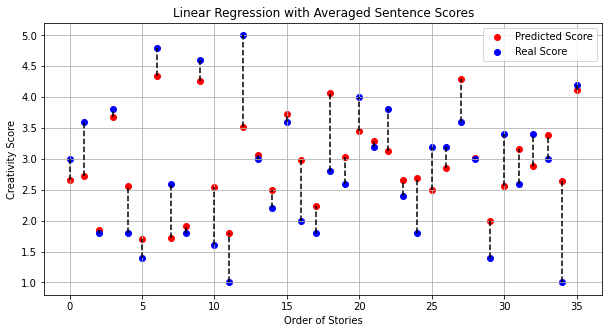

In [301]:
# Create a plot of the true vs. predicted creative scores
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred, color='red')
plt.scatter(avgData.index, Y_true, color='blue')
for i in range(len(storyID)):
  if Y_pred[i] >= Y_true[i]:
    topLim = Y_pred[i]
    botLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred[i]
    topLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Linear Regression with Averaged Sentence Scores")
plt.show()

## Model Evaluation on New Story Data

In [339]:
uploaded2 = files.upload()

Saving NEWStoryResults.csv to NEWStoryResults (1).csv


In [340]:
# Create dataframe with the new stories .csv file, using only the stamp-letter-send prompt
df = pd.read_csv('NEWStoryResults.csv')
df.head()

,ID,Story,RaterMean
0,1,Morgan wanted to write to her mom. Telling he...,4.00
1,2,I needed to send a letter for the last week. I...,1.50
2,3,"2 days ago, I tried to send a letter to my cou...",2.00
3,4,Don't you love writing letters? I know I do. I...,1.75
4,5,Dan is excited to send his letter to his grand...,2.50


In [341]:
# Convert all stories to lowercase for embedding to work with uncased model
for i in range(len(df['Story'])):
  df['Story'][i] = df['Story'][i].lower()

In [342]:
# Embed the new story data with the large BERT uncased model
predictions = pipe.predict(df.Story, output_level='document')
predictions

,sentence_embeddings@sent_bert_large_uncased_embeddings,origin_index,document_results
0,"[[-0.2662997245788574, 0.33801496028900146, -0...",0,morgan wanted to write to her mom. telling her...
1,"[[-0.2420838475227356, -0.011047550477087498, ...",1,i needed to send a letter for the last week. i...
2,"[[-0.35091227293014526, -0.13565585017204285, ...",2,"2 days ago, i tried to send a letter to my cou..."
3,"[[-0.19794288277626038, -0.12297322601079941, ...",3,don't you love writing letters? i know i do. i...
4,"[[-0.10653652250766754, 0.07413206249475479, -...",4,dan is excited to send his letter to his grand...
...,...,...,...
151,"[[-0.3595849275588989, -0.2719513773918152, -0...",151,"the candle flicks around the flame, dim and br..."
152,"[[-0.4146568775177002, -0.1587003618478775, -0...",152,i needed to send a letter to my pen pal. it wo...
153,"[[-0.3756798505783081, -0.23527710139751434, -...",153,i have 10 stamps to send gifts to the 10 peopl...
154,"[[-0.13578908145427704, -0.043099336326122284,...",154,gone are the days when we sent letters in the ...


In [343]:
# Add the rater mean to the table, so it can be used for testing labels later on
predictions["RaterMean"] = df["RaterMean"]

In [344]:
# Change the long name of the embeddings column to "embed"
predictions = predictions.rename(columns={'sentence_embeddings@sent_bert_large_uncased_embeddings':'embed'})

In [345]:
# Split the arrays for each story into their own sentence-by-sentence rows
# Store the embeddings
sent_embed = []
# Store the ID
story_id = []
# Store the labels of each story that the sentences belong to 
rater_score = []
for i in range(len(predictions['embed'])):
  for j in range(len(predictions['embed'][i])):
    sent_embed.append(predictions['embed'][i][j])
    story_id.append(predictions['origin_index'][i])
    rater_score.append(predictions['RaterMean'][i])

In [346]:
# Create a new dataframe where the rows are individual sentences from all the stories
# Start by making sure the sentences can be grouped later with the stories they belong to
model_data = pd.DataFrame(story_id)
# Add the embeddings
model_data['sent_embed'] = sent_embed
# Add the rater score for the story that each sentence belongs to
model_data['rater_score'] = rater_score
model_data = model_data.rename(columns={0:'story_id'})

In [347]:
# Create columns for each vector in the sentence embeddings
columns = []
for i in range(len(model_data["sent_embed"][0])):
  columns.append("Vector"+str(i))
len(columns)

1024

In [348]:
# Split the arrays into their respective vectors
embedData = pd.DataFrame(model_data['sent_embed'].to_list(), columns=columns)
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector984,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023
0,-0.266300,0.338015,-0.465588,0.175252,-0.642942,-0.410516,0.411661,0.309637,0.227900,0.079885,0.265642,-0.268447,-0.456191,-0.051256,0.343983,-0.167760,0.203531,-0.058401,-0.282293,-0.147325,-0.074051,0.129752,-0.000453,-0.416818,-0.531877,0.251376,0.311007,0.178543,0.072039,0.334920,-0.162224,-0.113652,-0.167017,-0.338817,0.043355,-0.391069,0.578634,0.016815,0.127839,-0.001362,...,0.147005,0.288692,-0.420563,0.160443,-0.438696,0.156556,0.096471,-0.123328,0.356324,-0.588812,-0.175675,0.326795,0.474954,0.480489,-0.237433,0.145517,-0.601654,0.274327,0.055578,0.545256,-0.005691,-0.710778,0.469314,0.029968,0.021107,0.249593,-0.028562,-0.244188,-0.089497,-0.063905,0.279591,0.225075,-0.486867,0.007222,-0.256432,0.271496,-0.113183,0.376971,0.017594,-0.160368
1,-0.251705,-0.212297,-0.063434,-0.010925,-0.007122,-0.186524,0.163281,0.164290,0.178904,-0.117763,0.284109,-0.227756,-0.105513,-0.414463,0.156747,-0.211378,-0.000998,-0.179833,0.038457,-0.261915,-0.270633,0.009141,-0.476910,-0.264658,-0.321186,0.186138,0.169269,-0.110335,0.500098,0.249982,-0.146929,0.127317,0.139890,-0.502673,-0.100819,0.054327,0.370048,0.012137,0.039674,-0.025939,...,0.176091,0.085580,-0.105024,0.048195,0.100622,-0.051397,-0.034829,-0.080248,-0.116911,-0.225067,0.156138,-0.031232,0.268926,0.240051,0.003790,0.084250,-0.359850,-0.021237,0.094234,0.112119,0.160184,-0.333959,0.211043,-0.011486,-0.192851,0.053685,-0.136895,-0.213666,-0.133440,-0.054827,0.075056,0.157167,-0.474546,-0.133306,0.114173,0.377247,0.077625,-0.091544,0.033626,0.052983
2,-0.318398,-0.106260,-0.047430,0.119616,-0.109352,-0.210489,0.358217,0.457134,0.306496,0.366844,0.580049,0.120987,-0.176610,-0.126649,-0.240302,-0.408958,0.371877,-0.209887,-0.216860,0.070163,-0.062929,0.139962,-0.473499,-0.586495,-0.354643,0.507515,0.158290,0.083809,0.439545,0.232143,-0.031700,0.405461,-0.081067,-0.242925,0.224129,-0.134588,0.178675,-0.037617,0.253956,-0.197213,...,0.106583,0.146456,-0.030378,0.052991,-0.240884,-0.047330,0.129941,-0.248017,-0.047523,-0.433217,0.313779,0.048470,0.420072,0.212344,-0.266500,0.656067,-0.557669,0.031186,-0.090288,-0.199606,0.264797,-0.642305,0.023010,0.169594,-0.434441,0.223484,-0.547810,0.074517,-0.121358,0.126982,0.195303,0.089775,-0.661379,-0.108454,0.181884,0.437086,-0.187712,-0.059800,0.037622,-0.065096
3,-0.414573,-0.066121,-0.194357,-0.094086,-0.239492,-0.177168,0.207095,0.331256,-0.022859,0.239271,0.121150,0.154782,-0.161714,-0.305695,0.009414,-0.124739,-0.139668,0.207293,0.356359,-0.249593,0.085308,0.224748,-0.475157,-0.327600,-0.223741,0.096956,0.320632,-0.047921,0.516918,0.550612,-0.299588,-0.068630,0.177470,-0.394701,-0.267856,0.138045,0.441447,-0.234585,0.075444,-0.152618,...,-0.123940,-0.084259,-0.335128,-0.069717,-0.399845,-0.182392,-0.097885,-0.169219,0.039499,-0.369175,-0.125967,0.194633,0.031581,0.302604,0.221823,0.101137,-0.186905,0.441939,0.045724,0.153253,0.209925,-0.516853,0.398369,0.026640,-0.610738,-0.020132,-0.199540,-0.254571,0.049593,0.231269,-0.060879,0.099170,-0.334307,0.090788,0.211430,0.496210,0.231694,-0.275858,0.011435,0.051290
4,-0.341867,0.187890,-0.218039,0.022578,-0.377659,0.132713,0.459418,0.534753,0.217657,-0.100933,0.283089,0.103610,-0.517122,0.111746,-0.032805,-0.298252,0.3

In [349]:
# Add the rater mean and story ID to the new table
embedData["RaterMean"] = model_data["rater_score"]
embedData["StoryID"] = model_data["story_id"]
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,RaterMean,StoryID
0,-0.266300,0.338015,-0.465588,0.175252,-0.642942,-0.410516,0.411661,0.309637,0.227900,0.079885,0.265642,-0.268447,-0.456191,-0.051256,0.343983,-0.167760,0.203531,-0.058401,-0.282293,-0.147325,-0.074051,0.129752,-0.000453,-0.416818,-0.531877,0.251376,0.311007,0.178543,0.072039,0.334920,-0.162224,-0.113652,-0.167017,-0.338817,0.043355,-0.391069,0.578634,0.016815,0.127839,-0.001362,...,-0.420563,0.160443,-0.438696,0.156556,0.096471,-0.123328,0.356324,-0.588812,-0.175675,0.326795,0.474954,0.480489,-0.237433,0.145517,-0.601654,0.274327,0.055578,0.545256,-0.005691,-0.710778,0.469314,0.029968,0.021107,0.249593,-0.028562,-0.244188,-0.089497,-0.063905,0.279591,0.225075,-0.486867,0.007222,-0.256432,0.271496,-0.113183,0.376971,0.017594,-0.160368,4.0,0
1,-0.251705,-0.212297,-0.063434,-0.010925,-0.007122,-0.186524,0.163281,0.164290,0.178904,-0.117763,0.284109,-0.227756,-0.105513,-0.414463,0.156747,-0.211378,-0.000998,-0.179833,0.038457,-0.261915,-0.270633,0.009141,-0.476910,-0.264658,-0.321186,0.186138,0.169269,-0.110335,0.500098,0.249982,-0.146929,0.127317,0.139890,-0.502673,-0.100819,0.054327,0.370048,0.012137,0.039674,-0.025939,...,-0.105024,0.048195,0.100622,-0.051397,-0.034829,-0.080248,-0.116911,-0.225067,0.156138,-0.031232,0.268926,0.240051,0.003790,0.084250,-0.359850,-0.021237,0.094234,0.112119,0.160184,-0.333959,0.211043,-0.011486,-0.192851,0.053685,-0.136895,-0.213666,-0.133440,-0.054827,0.075056,0.157167,-0.474546,-0.133306,0.114173,0.377247,0.077625,-0.091544,0.033626,0.052983,4.0,0
2,-0.318398,-0.106260,-0.047430,0.119616,-0.109352,-0.210489,0.358217,0.457134,0.306496,0.366844,0.580049,0.120987,-0.176610,-0.126649,-0.240302,-0.408958,0.371877,-0.209887,-0.216860,0.070163,-0.062929,0.139962,-0.473499,-0.586495,-0.354643,0.507515,0.158290,0.083809,0.439545,0.232143,-0.031700,0.405461,-0.081067,-0.242925,0.224129,-0.134588,0.178675,-0.037617,0.253956,-0.197213,...,-0.030378,0.052991,-0.240884,-0.047330,0.129941,-0.248017,-0.047523,-0.433217,0.313779,0.048470,0.420072,0.212344,-0.266500,0.656067,-0.557669,0.031186,-0.090288,-0.199606,0.264797,-0.642305,0.023010,0.169594,-0.434441,0.223484,-0.547810,0.074517,-0.121358,0.126982,0.195303,0.089775,-0.661379,-0.108454,0.181884,0.437086,-0.187712,-0.059800,0.037622,-0.065096,4.0,0
3,-0.414573,-0.066121,-0.194357,-0.094086,-0.239492,-0.177168,0.207095,0.331256,-0.022859,0.239271,0.121150,0.154782,-0.161714,-0.305695,0.009414,-0.124739,-0.139668,0.207293,0.356359,-0.249593,0.085308,0.224748,-0.475157,-0.327600,-0.223741,0.096956,0.320632,-0.047921,0.516918,0.550612,-0.299588,-0.068630,0.177470,-0.394701,-0.267856,0.138045,0.441447,-0.234585,0.075444,-0.152618,...,-0.335128,-0.069717,-0.399845,-0.182392,-0.097885,-0.169219,0.039499,-0.369175,-0.125967,0.194633,0.031581,0.302604,0.221823,0.101137,-0.186905,0.441939,0.045724,0.153253,0.209925,-0.516853,0.398369,0.026640,-0.610738,-0.020132,-0.199540,-0.254571,0.049593,0.231269,-0.060879,0.099170,-0.334307,0.090788,0.211430,0.496210,0.231694,-0.275858,0.011435,0.051290,4.0,0
4,-0.341867,0.187890,-0.218039,0.022578,-0.377659,0.132713,0.459418,0.534753,0.217657,-0.100933,0.283089,0.103610,-0.517122,0.111746,-0.032805,-0.298252,0.390193,0.101931,-0.136634,-0.178415,-0.091036,0.17440

In [350]:
# Create another dataframe for the first method that averages the embeddings of the sentences
# grouped by the stories that they are part of
modelData = embedData.groupby(['StoryID']).mean()

In [351]:
modelData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector985,Vector986,Vector987,Vector988,Vector989,Vector990,Vector991,Vector992,Vector993,Vector994,Vector995,Vector996,Vector997,Vector998,Vector999,Vector1000,Vector1001,Vector1002,Vector1003,Vector1004,Vector1005,Vector1006,Vector1007,Vector1008,Vector1009,Vector1010,Vector1011,Vector1012,Vector1013,Vector1014,Vector1015,Vector1016,Vector1017,Vector1018,Vector1019,Vector1020,Vector1021,Vector1022,Vector1023,RaterMean
StoryID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.286599,0.026932,-0.192733,2.449732e-02,-0.292346,-0.098187,0.357830,0.376308,0.154103,0.107982,0.244913,-0.033131,-0.360135,-0.168971,0.018270,-0.270936,0.164752,-0.004417,-0.019261,-0.208434,-0.086097,0.131835,-0.320418,-0.433499,-0.325005,0.315500,0.304265,-0.055808,0.400306,0.396660,-0.168787,0.103135,0.028362,-0.311738,-0.044778,-0.028701,0.368715,-0.055243,0.089581,-0.111203,...,0.106204,-0.201235,0.079398,-0.220077,-0.110453,0.041460,-0.185858,0.029334,-0.358900,0.039578,0.136958,0.197728,0.258278,-0.136175,0.252855,-0.432407,0.166102,-0.026820,0.142787,0.138686,-0.484485,0.303667,0.032512,-0.361457,0.120299,-0.299684,-0.181268,-0.068142,0.043858,0.146685,0.060579,-0.496405,-0.080858,0.191673,0.335562,0.043480,-0.051700,0.110275,-0.045284,4.00
1,-0.397343,-0.120979,-0.348276,-9.650620e-02,-0.355271,-0.013539,0.320610,0.338787,0.255264,0.417757,0.223100,0.054590,-0.486811,-0.182572,0.126776,-0.049833,0.005343,-0.190093,0.129899,-0.247023,-0.208220,-0.001089,-0.326633,-0.279203,-0.316367,0.152969,0.255935,-0.041125,0.143254,0.250257,0.067053,0.059212,0.181261,-0.414112,-0.114344,-0.068637,0.139949,-0.126847,0.090956,-0.265435,...,0.069935,-0.332991,-0.013790,-0.303299,-0.097716,0.012364,0.168768,0.118324,-0.337537,-0.313430,0.033549,0.206589,0.277482,-0.106422,0.061573,-0.193217,-0.007415,0.151031,-0.022824,0.246100,-0.454286,0.254726,0.124231,-0.445828,-0.068832,-0.253518,-0.238536,0.022573,-0.142951,0.188954,-0.003601,-0.386881,-0.181068,0.029675,0.300783,0.081740,-0.246347,0.078535,-0.025550,1.50
2,-0.576926,-0.093359,-0.328402,-1.914188e-02,-0.210805,-0.068370,0.472609,0.311696,0.258406,0.334984,0.248532,0.128545,-0.650278,-0.419711,0.065546,-0.249383,-0.008672,-0.136285,0.444200,-0.335494,-0.351653,-0.036356,-0.402281,-0.323625,-0.488724,0.173368,0.370467,-0.210310,-0.028501,0.432500,0.059287,-0.028739,0.258028,-0.728161,-0.168591,-0.041178,0.321097,-0.177266,0.237657,-0.218281,...,0.043574,-0.243557,-0.225452,-0.257647,-0.165298,0.170061,-0.161898,-0.222183,-0.348541,-0.263504,0.005029,-0.007573,0.480613,-0.145495,0.036276,-0.426918,0.012358,0.156342,-0.022882,0.289071,-0.621560,0.270196,0.060894,-0.442427,-0.098067,-0.382482,-0.358452,-0.007297,-0.189975,0.235194,0.096389,-0.476418,-0.050580,-0.009390,0.429524,-0.002145,-0.147453,0.233660,-0.049038,2.00
3,-0.183372,-0.044224,-0.319008,-2.194936e-02,-0.121913,-0.137133,0.257269,0.327469,0.066352,0.147142,0.103546,0.127492,-0.298854,-0.287519,0.090929,-0.551269,-0.250605,-0.250577,0.002416,-0.297706,-0.435741,0.064751,-0.339724,-0.218637,-0.205693,0.180537,0.291199,-0.005055,0.142639,0.610451,-0.297715,0.030182,0.204685,-0.408314,-0.086268,-0.050608,0.120477,-0.208076,0.107273,-0.162564,...,0.143381,-0.298062,-0.214998,-0.076418,-0.194723,0.107395,-0.065854,0.038559,-0.444923,-0.053582,0.074899,0.381286,0.080123,-0.258648,0.046292,-0.292304,0.104167,-0.203655,0.035805,-0.005008,-0.427008,0.306861,0.032584,-0.431830,-0.342335,-0.403462,-0.164814,-0.119244,-0.168267,0.235326,0.053697,-0.391388,-0.232529,0.056365,0.398835,0.116987,-0.123599,0.019405,-0.086189,1.75
4,-0.216085,-0.106891,-0.145466,9.777064e-02,-0.313

In [352]:
# Get the model data with the average of the embeddings
data = modelData
# Create a numpy array of the embeddings 
X_new = data.iloc[:, 0:1024].values#.reshape(-1, 1)
# Create a numpy array of the mean rater scores (labels)
Y_true = data.iloc[:, 1024].values#.reshape(-1, 1)
# Create a numpy array of the index for the stories
I = modelData.index.to_numpy()

In [353]:
# Predict the scores for the testing data with the averaged testing embeddings
Y_pred1 = linear_regressor.predict(X_new)
Y_pred2 = ridge_regressor.predict(X_new)
Y_pred5 = sgd_regressor.predict(X_new)

In [354]:
# Edit the prediction results to make sure that they are within the bounds of 0 and 5 for the context of the project
for i in range(len(Y_pred1)):
  if Y_pred1[i] < 0:
    Y_pred1[i] = 0
  elif Y_pred1[i] > 5:
    Y_pred1[i] = 5

for i in range(len(Y_pred2)):
  if Y_pred2[i] < 0:
    Y_pred2[i] = 0
  elif Y_pred2[i] > 5:
    Y_pred2[i] = 5

for i in range(len(Y_pred5)):
  if Y_pred5[i] < 0:
    Y_pred5[i] = 0
  elif Y_pred5[i] > 5:
    Y_pred5[i] = 5

In [355]:
# Explained Variance Score
evs = metrics.explained_variance_score(Y_true, Y_pred1)
# R-Squared Score
r2 = metrics.r2_score(Y_true, Y_pred1)
# Mean Absolute Error
mae = metrics.mean_absolute_error(Y_true, Y_pred1)
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(Y_true, Y_pred1): 
    Y_true, Y_pred1 = np.array(Y_true), np.array(Y_pred1)
    return np.mean(np.abs((Y_true - Y_pred1) / Y_true)) * 100

mape = mean_absolute_percentage_error(Y_true, Y_pred1)
# Mean Squared Error
mse = metrics.mean_squared_error(Y_true, Y_pred1)
# Root Mean Squared Error
rmse = metrics.mean_squared_error(Y_true, Y_pred1, squared=False)

print("Evaluation of Averaged Embeddings Method for Linear Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Linear Regression:
 
Explained Variance Score:  0.4451917678174623
R-Squared Score:  0.37382509609858594
Mean Absolute Error:  0.6126973035700027
Mean Absolute Percentage Error:  24.799677703733572
Mean Squared Error:  0.5886256801284676
Root Mean Squared Error:  0.7672194471782292


In [356]:
# Correlation
r = np.corrcoef(Y_true, Y_pred1)
print(r)

[[1.        0.6741432]
 [0.6741432 1.       ]]


In [357]:
evs = metrics.explained_variance_score(Y_true, Y_pred2)
r2 = metrics.r2_score(Y_true, Y_pred2)
mae = metrics.mean_absolute_error(Y_true, Y_pred2)
def mean_absolute_percentage_error(Y_true, Y_pred2): 
    Y_true, Y_pred2 = np.array(Y_true), np.array(Y_pred2)
    return np.mean(np.abs((Y_true - Y_pred2) / Y_true)) * 100
mape = mean_absolute_percentage_error(Y_true, Y_pred2)
mse = metrics.mean_squared_error(Y_true, Y_pred2)
rmse = metrics.mean_squared_error(Y_true, Y_pred2, squared=False)
print("Evaluation of Averaged Embeddings Method for Ridge Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Ridge Regression:
 
Explained Variance Score:  0.4909034479781048
R-Squared Score:  0.42568398918772643
Mean Absolute Error:  0.5905911485604793
Mean Absolute Percentage Error:  23.993402959198463
Mean Squared Error:  0.539876559036079
Root Mean Squared Error:  0.7347629270969508


In [358]:
# Correlation
r = np.corrcoef(Y_true, Y_pred2)
print(r)

[[1.        0.7006451]
 [0.7006451 1.       ]]


In [366]:
evs = metrics.explained_variance_score(Y_true, Y_pred5)
r2 = metrics.r2_score(Y_true, Y_pred5)
mae = metrics.mean_absolute_error(Y_true, Y_pred5)
def mean_absolute_percentage_error(Y_true, Y_pred5): 
    Y_true, Y_pred5 = np.array(Y_true), np.array(Y_pred5)
    return np.mean(np.abs((Y_true - Y_pred5) / Y_true)) * 100
mape = mean_absolute_percentage_error(Y_true, Y_pred5)
mse = metrics.mean_squared_error(Y_true, Y_pred5)
rmse = metrics.mean_squared_error(Y_true, Y_pred5, squared=False)
print("Evaluation of Averaged Embeddings Method for SGD Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for SGD Regression:
 
Explained Variance Score:  0.4914474619894196
R-Squared Score:  0.47505190227124017
Mean Absolute Error:  0.5773217198841245
Mean Absolute Percentage Error:  22.373363607731918
Mean Squared Error:  0.49346904376478434
Root Mean Squared Error:  0.7024735181946608


In [360]:
# Correlation
r = np.corrcoef(Y_true, Y_pred5)
print(r)

[[1.         0.70582427]
 [0.70582427 1.        ]]


In [361]:
# Create a dataframe with story ID, prediction results and true rater mean
avgData = pd.DataFrame(I)
avgData = avgData.rename(columns={0:'StoryID'})
avgData['predRaterMean_lin'] = Y_pred1
avgData['predRaterMean_ridge'] = Y_pred2
avgData['predRaterMean_sdg'] = Y_pred5
avgData['trueRaterMean'] = Y_true

In [362]:
avgData

,StoryID,predRaterMean_lin,predRaterMean_ridge,predRaterMean_sdg,trueRaterMean
0,0,2.700567,2.784842,2.868975,4.00
1,1,1.376216,1.646194,1.741505,1.50
2,2,2.085360,2.202480,2.130584,2.00
3,3,3.192511,3.299436,3.296995,1.75
4,4,2.603041,2.639016,2.912378,2.50
...,...,...,...,...,...
151,151,3.060644,3.084171,3.070791,3.50
152,152,2.976445,2.815579,2.526424,2.00
153,153,3.317842,3.227134,2.881518,3.50
154,154,3.474761,3.583782,3.676121,3.50


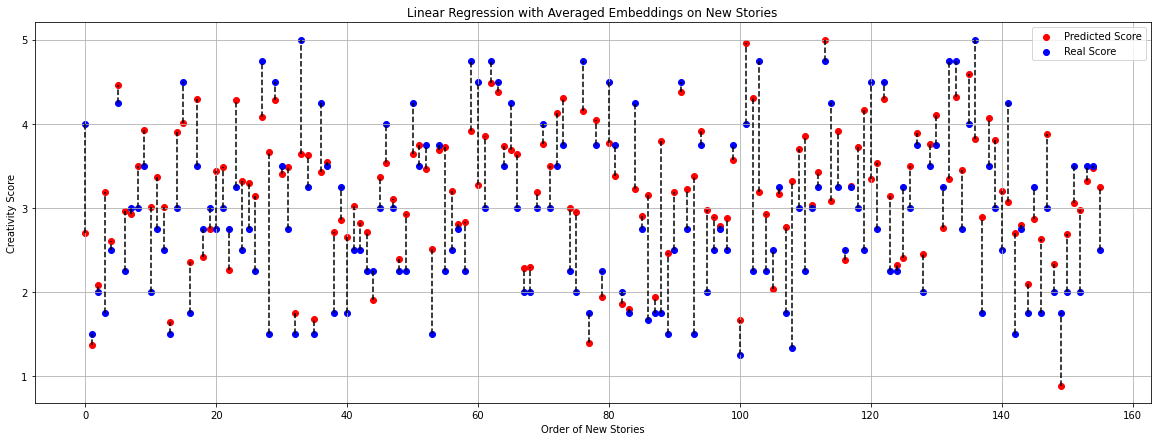

In [363]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(7)
plt.scatter(avgData.index, Y_pred1, color='red')
plt.scatter(avgData.index, Y_true, color='blue')
for i in range(len(I)):
  if Y_pred1[i] >= Y_true[i]:
    topLim = Y_pred1[i]
    botLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred1[i]
    topLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of New Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Linear Regression with Averaged Embeddings on New Stories")
plt.show()

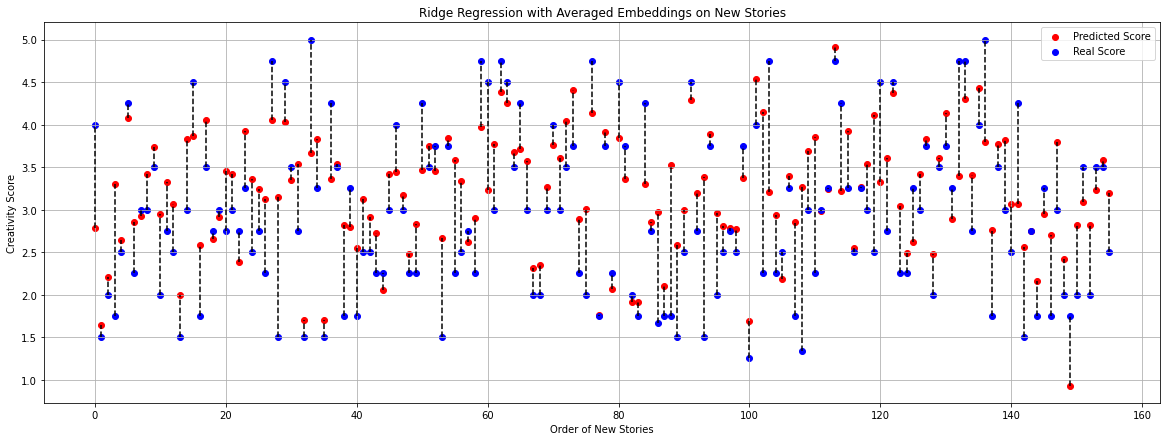

In [364]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(7)
plt.scatter(avgData.index, Y_pred2, color='red')
plt.scatter(avgData.index, Y_true, color='blue')
for i in range(len(I)):
  if Y_pred2[i] >= Y_true[i]:
    topLim = Y_pred2[i]
    botLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred2[i]
    topLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of New Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Ridge Regression with Averaged Embeddings on New Stories")
plt.show()

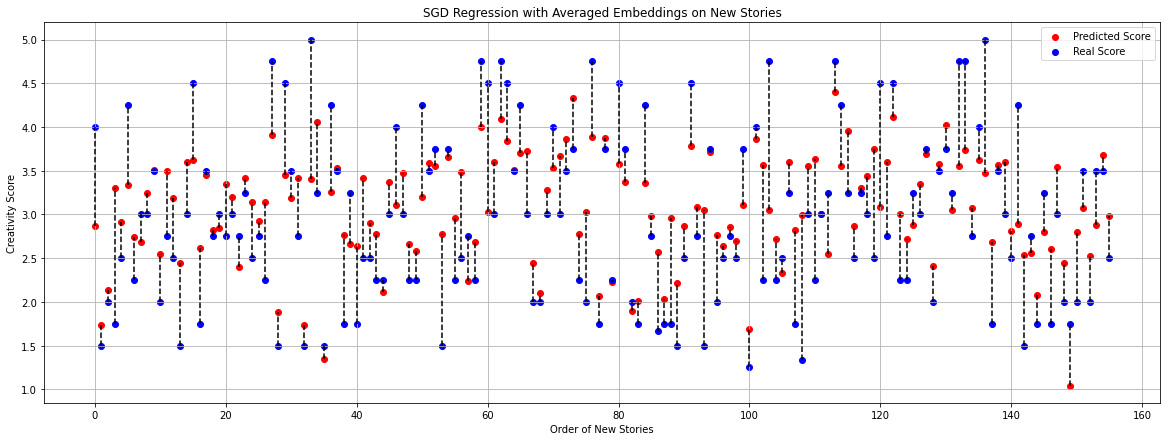

In [365]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(7)
plt.scatter(avgData.index, Y_pred5, color='red')
plt.scatter(avgData.index, Y_true, color='blue')
for i in range(len(I)):
  if Y_pred5[i] >= Y_true[i]:
    topLim = Y_pred5[i]
    botLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred5[i]
    topLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of New Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("SGD Regression with Averaged Embeddings on New Stories")
plt.show()

## Single Story Scoring Test

In [322]:
# Collect a story as input from the user
story = input("Enter a creative story: ")

Enter a creative story: I will send a letter to my mother in my absence, with a stamp that reflects the beauty of our hometown. I hope that she is satisfied, as the letter was carefully crafted and written with love.


In [323]:
a = [story]
# Create a dataframe with the single story
new_df = pd.DataFrame(a, columns = ['Story'])
# Give the story its sentence-by-sentence embeddings
pred = pipe.predict(new_df.Story, output_level='document')

In [324]:
# Observe the dataframe
pred

,sentence_embeddings@sent_bert_large_uncased_embeddings,origin_index,document_results
0,"[[-0.6529098749160767, -0.30449140071868896, -...",0,I will send a letter to my mother in my absenc...


In [325]:
# Simplify the name of the embeddings column
pred = pred.rename(columns={'sentence_embeddings@sent_bert_large_uncased_embeddings':'embed'})

In [327]:
# Drop the index column (uneeded)
pred = pred.drop(["origin_index"], axis=1)

In [329]:
# Split the story embeddings into individual sentence embeddings as arrays
sent_embed = []

for j in range(len(pred['embed'][0])):
  sent_embed.append(pred['embed'][0][j])

In [331]:
# Create a dataframe of the embeddings, with each sentence as a row
scoring_data = pd.DataFrame()
scoring_data['sent_embed'] = sent_embed

In [333]:
# Create the embedding vector columns
columns = []
for i in range(len(pred['embed'][0][0])):
  columns.append("Vector"+str(i))
len(columns)

1024

In [334]:
# Put the embeddings back into an array for model prediction
embedData = pd.DataFrame(scoring_data['sent_embed'].to_list(), columns=columns)
data = embedData  # load data set
X_new = data.iloc[:, 0:1024].values
# Get predictions for the single story sentences with linear regression model from above
Y_p = linear_regressor.predict(X_new)

In [336]:
# Calculate the average of the sentence scores (if we are using this method) and produce the final score
finalScore = np.average(Y_p)
finalScore

2.7938308111658596

In [337]:
# Make sure the predicted score is within the bounds of 0-5
if finalScore > 5:
  finalScore = 5
elif finalScore < 0:
  finalScore = 0

In [338]:
# Print the results for the user to see how creative their story is
print("The creativity score for your story is ", round(finalScore, 2), "!")

The creativity score for your story is  2.79 !
